## Analyzes bootstraps/toys for a set of directories,

Sets of input directories are runs with different detector resolutions.

Will do the following:
- Calculate the model parameters (mu, sig2) using OmniFold output weighted events.
    - __Results__: mean mu, mean sig2, RMS mu, RMS sig2
- Read unbinned ML fit results (for about 50 samples) 
    - __Results__: ave fit error for mu and sig2
- Make histogram of OmniFold output and compute covariance matrix for histogram from set of samples
- Run chi2 fit of histogram using full covariance matrix
    - __Results__: mean mu, mean sig2, ave fit err mu, ave fit err sig2, RMS of fit mu, RMS of fit sig2
- Run chi2 fit of histogram using only diagonal elements of covariance matrix
    - __Results__: mean mu, mean sig2, ave fit err mu, ave fit err sig2, RMS of fit mu, RMS of fit sig2


Summary tables and plots will have
- 3 types of inference mean for each model parameter (mu, sig2):  ML/simple calc, chi2 fit full cov, chi2 fit diag cov.
- 3 types of asymptotic error for each model parameter: unbinned ML fit, chi2 fit full cov, chi2 fit diag cov.
- 3 types of RMS of inference values for each model parameter: ML/simple calc, chi2 fit full cov, chi2 fit diag cov.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import special


import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl



import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
n_input_dirs = 8

n_pars = 2

par_names = [ 'mu', 'sig2' ]




set_number = 4

if set_number == 0 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-1a-perfect',
        'hist-pdf-toy-study-1d-1a-goodres',
        'hist-pdf-toy-study-1d-1a-nominal-resolution',
        'hist-pdf-toy-study-1d-1b-mediumbad',
        'bootstrap-toy-study8a-1d-1d-perfect',
        'bootstrap-toy-study8a-1d-1d-goodres',
        'bootstrap-toy-study8a-1d-1d-nominal-resolution',
        'bootstrap-toy-study8a-1d-1d-mediumbad',
    ])

if set_number == 1 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-2a-perfect',
        'hist-pdf-toy-study-1d-2a-goodres',
        'hist-pdf-toy-study-1d-2a-nominal-resolution',
        'hist-pdf-toy-study-1d-2a-mediumbad',
        'bootstrap-toy-study8a-1d-2a-perfect',
        'bootstrap-toy-study8a-1d-2a-goodres',
        'bootstrap-toy-study8a-1d-2a-nominal-resolution',
        'bootstrap-toy-study8a-1d-2a-mediumbad',
    ])

if set_number == 2 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-2a-discretized-data-perfect',
        'hist-pdf-toy-study-1d-2a-discretized-data-goodres',
        'hist-pdf-toy-study-1d-2a-discretized-data-nominal-resolution',
        'hist-pdf-toy-study-1d-2a-discretized-data-mediumbad',
        'bootstrap-toy-study8a-1d-1d-perfect',
        'bootstrap-toy-study8a-1d-1d-goodres',
        'bootstrap-toy-study8a-1d-1d-nominal-resolution',
        'bootstrap-toy-study8a-1d-1d-mediumbad',
    ])
    
if set_number == 3 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-3b-perfect',
        'hist-pdf-toy-study-1d-3b-goodres',
        'hist-pdf-toy-study-1d-3b-nominal-resolution',
        'hist-pdf-toy-study-1d-3b-mediumbad',
        'bootstrap-toy-study8a-1d-1d-perfect',
        'bootstrap-toy-study8a-1d-1d-goodres',
        'bootstrap-toy-study8a-1d-1d-nominal-resolution',
        'bootstrap-toy-study8a-1d-1d-mediumbad',
    ])    
    
if set_number == 4 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-3c-perfect',
        'hist-pdf-toy-study-1d-3c-goodres',
        'hist-pdf-toy-study-1d-3c-nominal-resolution',
        'hist-pdf-toy-study-1d-3c-mediumbad',
        'bootstrap-toy-study8a-1d-1d-perfect',
        'bootstrap-toy-study8a-1d-1d-goodres',
        'bootstrap-toy-study8a-1d-1d-nominal-resolution',
        'bootstrap-toy-study8a-1d-1d-mediumbad',
    ])    
    
   
    
input_names = np.array([
    'Simple PDF, perfect det. res.',
    'Simple PDF, good det. res.',
    'Simple PDF, nominal det. res.',
    'Simple PDF, bad det. res.',
    'Neural Network, perfect det. res.',
    'Neural Network, good det. res.',
    'Neural Network, nominal det. res.',
    'Neural Network, bad det. res.',
])

input_det_res = np.array([
    0.0,
    0.25,
    0.50,
    0.75,
    0.0,
    0.25,
    0.50,
    0.75,
])

input_lhr_type = np.array([
    'Simple PDF',
    'Simple PDF',
    'Simple PDF',
    'Simple PDF',
    'Neural Network',
    'Neural Network',
    'Neural Network',
    'Neural Network',
])


n_inference_types = 3

inference_names = np.array([
    'Unbinned ML fit',
    'chi2 fit, full cov.',
    'chi2 fit, diag. cov.',
])



results_inference_mean = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )

results_fit_err = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )

results_rms = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )




results_inference_mean_stat_err = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )

results_fit_err_stat_err = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )

results_rms_stat_err = np.zeros( shape=(n_input_dirs, n_inference_types, n_pars) )




#hist_nbins = 10
hist_nbins = 20
#hist_nbins = 40


#fitType = 'bin center approximation'
fitType = 'integral within bin'


hist_xlow = -3.
hist_xhigh = 3.

#hist_xlow = -2.
#hist_xhigh = 2.




rcond_val = 0.001

diagonal_constant = 1.
#diagonal_constant = 0


In [3]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [4]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

## Loop over input directories



 ====== Input dir: hist-pdf-toy-study-1d-3c-perfect :  Simple PDF, perfect det. res.
    Unfolding type: Simple PDF ,   detector resolution:  0.00



 shape of train_pts:  (100000, 1)
 shape of true_pts:   (10000, 1)



 shape of main_sample_omnifold_weights: (100000,)


 Sum of ominfold weights:  9987.329

 Simple calculation of model pars:     mean = 0.18843,     sig2 = 0.81052

 Found 500 bootstrap samples.


 boot   0 weights: [0.084534   0.08361008 0.0830566  ... 0.10279442 0.084534   0.08471007]
 boot   1 weights: [0.09038464 0.07488497 0.07983871 ... 0.10408048 0.09038464 0.07918013]
 boot   2 weights: [0.08291305 0.07980799 0.08129141 ... 0.10994887 0.08291305 0.07952273]
 boot   3 weights: [0.08775671 0.08536863 0.0833161  ... 0.10558707 0.08775671 0.08243591]
 boot   4 weights: [0.08642018 0.07524524 0.07802673 ... 0.10270163 0.08642018 0.07714389]
 boot   5 weights: [0.08825421 0.08129512 0.09083151 ... 0.09998422 0.08825421 0.08927884]
 boot   6 weights: [0.09085504 0.080

 boot 100 weights: [0.08757568 0.07754068 0.08061327 ... 0.10232038 0.08757568 0.07974054]
 boot 101 weights: [0.09688392 0.08120512 0.08122586 ... 0.11067002 0.09688392 0.0807343 ]
 boot 102 weights: [0.086943   0.08137206 0.08725088 ... 0.1073932  0.086943   0.08520502]
 boot 103 weights: [0.09442005 0.07968392 0.08588031 ... 0.10209419 0.09442005 0.08397041]
 boot 104 weights: [0.09402648 0.07897729 0.08117123 ... 0.10795957 0.09402648 0.08032454]
 boot 105 weights: [0.09491214 0.0777783  0.08456375 ... 0.10995052 0.09491214 0.08450587]
 boot 106 weights: [0.09036217 0.07813152 0.08488114 ... 0.10704822 0.09036217 0.08320634]
 boot 107 weights: [0.09683869 0.0776552  0.0852327  ... 0.11455415 0.09683869 0.08339459]
 boot 108 weights: [0.08914844 0.08409288 0.0875693  ... 0.10983646 0.08914844 0.08860539]
 boot 109 weights: [0.09081722 0.0777697  0.09005764 ... 0.11421725 0.09081722 0.08884373]
 boot 110 weights: [0.08969819 0.07853071 0.08163909 ... 0.11077691 0.08969819 0.08108706]

 boot 207 weights: [0.09258227 0.08378402 0.08932154 ... 0.10878417 0.09258227 0.0882567 ]
 boot 208 weights: [0.09401516 0.07933365 0.08122713 ... 0.11601573 0.09401516 0.08089517]
 boot 209 weights: [0.08709112 0.08564032 0.09144604 ... 0.10544755 0.08709112 0.08939541]
 boot 210 weights: [0.09414055 0.07742385 0.08124722 ... 0.10352451 0.09414055 0.08059562]
 boot 211 weights: [0.08853142 0.08137115 0.08148866 ... 0.11029151 0.08853142 0.08227113]
 boot 212 weights: [0.09001235 0.0762331  0.08392638 ... 0.11190586 0.09001235 0.08244448]
 boot 213 weights: [0.08487964 0.07342204 0.08884583 ... 0.11030984 0.08487964 0.08492807]
 boot 214 weights: [0.09781347 0.08639171 0.08040221 ... 0.1104065  0.09781347 0.08175681]
 boot 215 weights: [0.08895192 0.07676674 0.0798799  ... 0.11191393 0.08895192 0.08071564]
 boot 216 weights: [0.08563912 0.07490388 0.07865591 ... 0.10608784 0.08563912 0.07721942]
 boot 217 weights: [0.09536225 0.08389461 0.09267439 ... 0.10235036 0.09536225 0.09266499]

 boot 312 weights: [0.09296073 0.07484429 0.08316905 ... 0.11300907 0.09296073 0.08095269]
 boot 313 weights: [0.09052363 0.07469329 0.08292364 ... 0.10195057 0.09052363 0.08163091]
 boot 314 weights: [0.08947336 0.08424551 0.08668086 ... 0.11111441 0.08947336 0.08778333]
 boot 315 weights: [0.08562313 0.07708721 0.08495381 ... 0.11200595 0.08562313 0.08247257]
 boot 316 weights: [0.08801277 0.09168144 0.08886123 ... 0.1032211  0.08801277 0.08948505]
 boot 317 weights: [0.0999152  0.08716977 0.08763894 ... 0.10949908 0.0999152  0.08639087]
 boot 318 weights: [0.08384821 0.07783941 0.08102683 ... 0.10100737 0.08384821 0.07995495]
 boot 319 weights: [0.09140935 0.07310671 0.08079509 ... 0.10849217 0.09140935 0.0779558 ]
 boot 320 weights: [0.09478124 0.07752227 0.08521855 ... 0.10093769 0.09478124 0.0830374 ]
 boot 321 weights: [0.09360883 0.08544288 0.08653808 ... 0.10959693 0.09360883 0.08718208]
 boot 322 weights: [0.0912176  0.08223746 0.08487634 ... 0.10866862 0.0912176  0.08494674]

 boot 414 weights: [0.08628641 0.07198269 0.07458068 ... 0.10830396 0.08628641 0.07395764]
 boot 415 weights: [0.0850006  0.08539587 0.0839388  ... 0.10291772 0.0850006  0.08426917]
 boot 416 weights: [0.09028562 0.07581584 0.08010778 ... 0.10964078 0.09028562 0.08005667]
 boot 417 weights: [0.086986   0.08400947 0.08665678 ... 0.10503418 0.086986   0.087069  ]
 boot 418 weights: [0.09012721 0.07744913 0.08493326 ... 0.10982388 0.09012721 0.08413585]
 boot 419 weights: [0.09063417 0.07841021 0.08205597 ... 0.10829634 0.09063417 0.0799821 ]
 boot 420 weights: [0.0853232  0.08544199 0.08760377 ... 0.11197296 0.0853232  0.08787704]
 boot 421 weights: [0.09060737 0.08449598 0.09798768 ... 0.10686131 0.09060737 0.09640521]
 boot 422 weights: [0.08875487 0.0811117  0.0833605  ... 0.10985053 0.08875487 0.08251751]
 boot 423 weights: [0.09054533 0.07849725 0.0761982  ... 0.10985986 0.09054533 0.07461255]
 boot 424 weights: [0.09521687 0.07754633 0.08893916 ... 0.10980577 0.09521687 0.08560232]

   2 : mu   0.2024 +/-   0.0090  (  0.2004 +/-   0.0084)    sig2   0.7984 +/-   0.0118  (  0.7983 +/-   0.0109)
   3 : mu   0.1956 +/-   0.0090  (  0.1952 +/-   0.0084)    sig2   0.8079 +/-   0.0121  (  0.8098 +/-   0.0112)
   4 : mu   0.2191 +/-   0.0090  (  0.2219 +/-   0.0084)    sig2   0.8037 +/-   0.0123  (  0.8036 +/-   0.0114)
   5 : mu   0.2297 +/-   0.0090  (  0.2300 +/-   0.0085)    sig2   0.8260 +/-   0.0121  (  0.8235 +/-   0.0111)
   6 : mu   0.2137 +/-   0.0090  (  0.2145 +/-   0.0084)    sig2   0.8021 +/-   0.0120  (  0.8004 +/-   0.0111)
   7 : mu   0.1926 +/-   0.0090  (  0.1943 +/-   0.0084)    sig2   0.8160 +/-   0.0122  (  0.8163 +/-   0.0114)
   8 : mu   0.1869 +/-   0.0090  (  0.1855 +/-   0.0085)    sig2   0.8232 +/-   0.0120  (  0.8217 +/-   0.0112)
   9 : mu   0.1986 +/-   0.0090  (  0.1992 +/-   0.0084)    sig2   0.8157 +/-   0.0121  (  0.8136 +/-   0.0112)
  10 : mu   0.1888 +/-   0.0090  (  0.1900 +/-   0.0084)    sig2   0.8180 +/-   0.0122  (  0.8184 +/-   

 108 : mu   0.1947 +/-   0.0090  (  0.1954 +/-   0.0084)    sig2   0.8153 +/-   0.0123  (  0.8136 +/-   0.0114)
 109 : mu   0.2044 +/-   0.0090  (  0.2034 +/-   0.0084)    sig2   0.8043 +/-   0.0122  (  0.8063 +/-   0.0113)
 110 : mu   0.1892 +/-   0.0090  (  0.1895 +/-   0.0085)    sig2   0.8238 +/-   0.0123  (  0.8247 +/-   0.0114)
 111 : mu   0.2044 +/-   0.0090  (  0.2043 +/-   0.0084)    sig2   0.7973 +/-   0.0120  (  0.7983 +/-   0.0111)
 112 : mu   0.2100 +/-   0.0090  (  0.2093 +/-   0.0084)    sig2   0.7888 +/-   0.0120  (  0.7907 +/-   0.0111)
 113 : mu   0.2008 +/-   0.0090  (  0.2015 +/-   0.0084)    sig2   0.8060 +/-   0.0119  (  0.8075 +/-   0.0110)
 114 : mu   0.1966 +/-   0.0090  (  0.1968 +/-   0.0084)    sig2   0.7948 +/-   0.0118  (  0.7953 +/-   0.0109)
 115 : mu   0.1990 +/-   0.0090  (  0.1991 +/-   0.0085)    sig2   0.8163 +/-   0.0120  (  0.8171 +/-   0.0112)
 116 : mu   0.1939 +/-   0.0090  (  0.1928 +/-   0.0085)    sig2   0.8165 +/-   0.0120  (  0.8169 +/-   

 216 : mu   0.2088 +/-   0.0090  (  0.2093 +/-   0.0084)    sig2   0.7779 +/-   0.0120  (  0.7789 +/-   0.0111)
 217 : mu   0.1891 +/-   0.0090  (  0.1923 +/-   0.0084)    sig2   0.8017 +/-   0.0121  (  0.8018 +/-   0.0112)
 218 : mu   0.1935 +/-   0.0090  (  0.1936 +/-   0.0084)    sig2   0.8104 +/-   0.0120  (  0.8098 +/-   0.0112)
 219 : mu   0.2005 +/-   0.0090  (  0.1991 +/-   0.0084)    sig2   0.7993 +/-   0.0118  (  0.8007 +/-   0.0110)
 220 : mu   0.1951 +/-   0.0090  (  0.1938 +/-   0.0084)    sig2   0.8040 +/-   0.0120  (  0.8055 +/-   0.0112)
 221 : mu   0.2093 +/-   0.0090  (  0.2073 +/-   0.0085)    sig2   0.8299 +/-   0.0123  (  0.8301 +/-   0.0115)
 222 : mu   0.2086 +/-   0.0090  (  0.2089 +/-   0.0085)    sig2   0.8210 +/-   0.0122  (  0.8225 +/-   0.0113)
 223 : mu   0.1931 +/-   0.0090  (  0.1900 +/-   0.0085)    sig2   0.8213 +/-   0.0121  (  0.8201 +/-   0.0112)
 224 : mu   0.1990 +/-   0.0090  (  0.2007 +/-   0.0084)    sig2   0.8184 +/-   0.0122  (  0.8192 +/-   

 324 : mu   0.1981 +/-   0.0090  (  0.1962 +/-   0.0085)    sig2   0.8208 +/-   0.0121  (  0.8237 +/-   0.0113)
 325 : mu   0.2144 +/-   0.0090  (  0.2181 +/-   0.0085)    sig2   0.8245 +/-   0.0122  (  0.8239 +/-   0.0112)
 326 : mu   0.1853 +/-   0.0090  (  0.1846 +/-   0.0084)    sig2   0.8164 +/-   0.0122  (  0.8143 +/-   0.0113)
 327 : mu   0.2119 +/-   0.0090  (  0.2129 +/-   0.0085)    sig2   0.8193 +/-   0.0120  (  0.8220 +/-   0.0112)
 328 : mu   0.1904 +/-   0.0090  (  0.1886 +/-   0.0085)    sig2   0.8212 +/-   0.0120  (  0.8229 +/-   0.0111)
 329 : mu   0.2054 +/-   0.0090  (  0.2070 +/-   0.0084)    sig2   0.8109 +/-   0.0121  (  0.8088 +/-   0.0112)
 330 : mu   0.1971 +/-   0.0090  (  0.1984 +/-   0.0084)    sig2   0.8078 +/-   0.0120  (  0.8062 +/-   0.0112)
 331 : mu   0.2010 +/-   0.0090  (  0.1999 +/-   0.0085)    sig2   0.8392 +/-   0.0122  (  0.8394 +/-   0.0113)
 332 : mu   0.1998 +/-   0.0090  (  0.2001 +/-   0.0084)    sig2   0.7980 +/-   0.0120  (  0.7983 +/-   

 432 : mu   0.2052 +/-   0.0090  (  0.2069 +/-   0.0084)    sig2   0.7887 +/-   0.0119  (  0.7869 +/-   0.0110)
 433 : mu   0.2044 +/-   0.0090  (  0.2059 +/-   0.0084)    sig2   0.8166 +/-   0.0121  (  0.8147 +/-   0.0112)
 434 : mu   0.1876 +/-   0.0090  (  0.1898 +/-   0.0084)    sig2   0.8013 +/-   0.0121  (  0.7979 +/-   0.0112)
 435 : mu   0.2031 +/-   0.0090  (  0.2053 +/-   0.0084)    sig2   0.7904 +/-   0.0122  (  0.7910 +/-   0.0114)
 436 : mu   0.1881 +/-   0.0090  (  0.1919 +/-   0.0084)    sig2   0.8145 +/-   0.0123  (  0.8119 +/-   0.0114)
 437 : mu   0.1977 +/-   0.0090  (  0.1975 +/-   0.0084)    sig2   0.8099 +/-   0.0121  (  0.8088 +/-   0.0112)
 438 : mu   0.2100 +/-   0.0090  (  0.2063 +/-   0.0085)    sig2   0.8193 +/-   0.0120  (  0.8208 +/-   0.0111)
 439 : mu   0.2044 +/-   0.0090  (  0.2029 +/-   0.0085)    sig2   0.8317 +/-   0.0122  (  0.8318 +/-   0.0113)
 440 : mu   0.2068 +/-   0.0090  (  0.2064 +/-   0.0085)    sig2   0.8200 +/-   0.0123  (  0.8200 +/-   

 boot  14 weights: [0.12392927 0.1206029  0.06728186 ... 0.09163291 0.08918972 0.12137807]
 boot  15 weights: [0.12291574 0.11747309 0.06878011 ... 0.09454567 0.09335646 0.12886832]
 boot  16 weights: [0.12656457 0.11289958 0.06878069 ... 0.09442708 0.09326286 0.11397674]
 boot  17 weights: [0.1268528  0.11719451 0.06710176 ... 0.08710108 0.08588227 0.1241549 ]
 boot  18 weights: [0.11918098 0.1179303  0.06754734 ... 0.0936669  0.09145869 0.12141873]
 boot  19 weights: [0.12907385 0.1185438  0.07063819 ... 0.09025071 0.09027845 0.11317035]
 boot  20 weights: [0.12977299 0.11736838 0.0695684  ... 0.09182978 0.09064835 0.10739472]
 boot  21 weights: [0.12865872 0.11454185 0.0641501  ... 0.09420657 0.09250365 0.10902051]
 boot  22 weights: [0.12450518 0.1118163  0.06589033 ... 0.09400035 0.09208756 0.12970793]
 boot  23 weights: [0.13350176 0.11584487 0.06580629 ... 0.09319121 0.09131278 0.12324358]
 boot  24 weights: [0.13226207 0.1170573  0.06864195 ... 0.09108564 0.09015263 0.106144  ]

 boot 106 weights: [0.13190584 0.11493623 0.06557128 ... 0.09443065 0.09340196 0.10651272]
 boot 107 weights: [0.11694602 0.12037634 0.07372397 ... 0.09399594 0.09281727 0.11299547]
 boot 108 weights: [0.13254083 0.11461195 0.06889632 ... 0.09130414 0.09052727 0.10672558]
 boot 109 weights: [0.12000592 0.12470337 0.07024856 ... 0.0893027  0.08764574 0.11354133]
 boot 110 weights: [0.12583915 0.11129973 0.06645148 ... 0.09455262 0.09284059 0.12280936]
 boot 111 weights: [0.12645016 0.12046124 0.06994613 ... 0.09029493 0.08974136 0.11243036]
 boot 112 weights: [0.12481681 0.11089257 0.0794124  ... 0.09072273 0.08878038 0.11892221]
 boot 113 weights: [0.12316378 0.11712908 0.06867856 ... 0.09326961 0.0918239  0.11066158]
 boot 114 weights: [0.1198201  0.11622384 0.07440735 ... 0.09205519 0.09103234 0.11436506]
 boot 115 weights: [0.12424465 0.11463638 0.06979194 ... 0.09241186 0.09069628 0.11280773]
 boot 116 weights: [0.12183927 0.11676604 0.06777636 ... 0.09535713 0.09402609 0.12481683]

 boot 219 weights: [0.12810061 0.12649459 0.06742427 ... 0.08700567 0.08619418 0.11627387]
 boot 220 weights: [0.12956409 0.11632136 0.06881231 ... 0.09236377 0.09105728 0.12019098]
 boot 221 weights: [0.12728303 0.11697049 0.064476   ... 0.09993576 0.09839156 0.11303092]
 boot 222 weights: [0.12424082 0.12109771 0.06729534 ... 0.09182741 0.0903543  0.11496094]
 boot 223 weights: [0.13229295 0.11257068 0.07181997 ... 0.08721905 0.0857478  0.11413661]
 boot 224 weights: [0.12440832 0.12326838 0.07182387 ... 0.09077003 0.08966751 0.11318891]
 boot 225 weights: [0.12416067 0.12065487 0.07565614 ... 0.0917282  0.09126274 0.10977636]
 boot 226 weights: [0.1307064  0.11626658 0.06542266 ... 0.08646582 0.08539496 0.12150878]
 boot 227 weights: [0.12027425 0.11740898 0.07346418 ... 0.08652774 0.08630543 0.12666913]
 boot 228 weights: [0.12621111 0.11936071 0.06541625 ... 0.09166121 0.08998741 0.11922511]
 boot 229 weights: [0.12404195 0.11528073 0.06950854 ... 0.09102961 0.09002366 0.11715817]

 boot 310 weights: [0.1323421  0.10751304 0.07597808 ... 0.0914935  0.09078782 0.11272745]
 boot 311 weights: [0.12315828 0.12100876 0.07156581 ... 0.09246787 0.09121294 0.1132206 ]
 boot 312 weights: [0.12326676 0.11234122 0.07750124 ... 0.09012197 0.08876092 0.11684728]
 boot 313 weights: [0.12214466 0.11583244 0.07106596 ... 0.09530201 0.0940454  0.12197633]
 boot 314 weights: [0.12392991 0.11723628 0.06952734 ... 0.095203   0.09423613 0.11448429]
 boot 315 weights: [0.12442464 0.11967275 0.07355129 ... 0.0908784  0.08958481 0.1081178 ]
 boot 316 weights: [0.1292289  0.10915114 0.0672569  ... 0.09392392 0.09152341 0.11585968]
 boot 317 weights: [0.12034224 0.11695876 0.06665911 ... 0.09757037 0.09526912 0.11643611]
 boot 318 weights: [0.12893893 0.11754489 0.06979002 ... 0.08904579 0.08779385 0.11193859]
 boot 319 weights: [0.12369595 0.11144509 0.06709168 ... 0.09426006 0.0927816  0.11755019]
 boot 320 weights: [0.12944947 0.12496206 0.06780398 ... 0.0899927  0.08890114 0.10353108]

 boot 417 weights: [0.13464406 0.11515622 0.06911155 ... 0.09341379 0.09304614 0.10530498]
 boot 418 weights: [0.1226242  0.11818128 0.0718479  ... 0.0872144  0.08614303 0.12749816]
 boot 419 weights: [0.12407262 0.11839357 0.07342717 ... 0.09186364 0.09006617 0.11089978]
 boot 420 weights: [0.13288749 0.11415248 0.07311562 ... 0.08747448 0.08538093 0.10417908]
 boot 421 weights: [0.12775135 0.11657954 0.06923071 ... 0.09388792 0.09268357 0.12512645]
 boot 422 weights: [0.12600615 0.11946147 0.07314922 ... 0.09126455 0.09091102 0.10839361]
 boot 423 weights: [0.12603125 0.12398258 0.06465405 ... 0.08885871 0.08835743 0.11282735]
 boot 424 weights: [0.12694784 0.11865072 0.06797902 ... 0.09162683 0.08956511 0.11508702]
 boot 425 weights: [0.12138615 0.11661436 0.06421035 ... 0.0962679  0.0948488  0.11850592]
 boot 426 weights: [0.12042203 0.11767702 0.07689384 ... 0.08912574 0.08737318 0.11588702]
 boot 427 weights: [0.12692575 0.1133113  0.06569802 ... 0.09308586 0.09059745 0.11864478]

   4 : mu   0.2010 +/-   0.0094  (  0.2046 +/-   0.0085)    sig2   0.7938 +/-   0.0137  (  0.7923 +/-   0.0113)
   5 : mu   0.2041 +/-   0.0095  (  0.2029 +/-   0.0085)    sig2   0.7964 +/-   0.0139  (  0.8008 +/-   0.0113)
   6 : mu   0.2065 +/-   0.0095  (  0.2088 +/-   0.0086)    sig2   0.8307 +/-   0.0143  (  0.8292 +/-   0.0117)
   7 : mu   0.1890 +/-   0.0094  (  0.1946 +/-   0.0086)    sig2   0.8369 +/-   0.0140  (  0.8318 +/-   0.0114)
   8 : mu   0.2163 +/-   0.0095  (  0.2168 +/-   0.0085)    sig2   0.8192 +/-   0.0142  (  0.8188 +/-   0.0116)
   9 : mu   0.2124 +/-   0.0094  (  0.2139 +/-   0.0085)    sig2   0.8208 +/-   0.0145  (  0.8185 +/-   0.0117)
  10 : mu   0.1968 +/-   0.0094  (  0.2001 +/-   0.0085)    sig2   0.8229 +/-   0.0143  (  0.8216 +/-   0.0117)
  11 : mu   0.2056 +/-   0.0094  (  0.2065 +/-   0.0085)    sig2   0.7844 +/-   0.0138  (  0.7864 +/-   0.0114)
  12 : mu   0.2015 +/-   0.0095  (  0.2036 +/-   0.0085)    sig2   0.8151 +/-   0.0139  (  0.8192 +/-   

 109 : mu   0.2014 +/-   0.0094  (  0.2020 +/-   0.0085)    sig2   0.8174 +/-   0.0142  (  0.8107 +/-   0.0116)
 110 : mu   0.2088 +/-   0.0095  (  0.2099 +/-   0.0085)    sig2   0.8355 +/-   0.0142  (  0.8343 +/-   0.0115)
 111 : mu   0.2030 +/-   0.0095  (  0.2047 +/-   0.0085)    sig2   0.7974 +/-   0.0139  (  0.7974 +/-   0.0114)
 112 : mu   0.1967 +/-   0.0095  (  0.1975 +/-   0.0085)    sig2   0.8256 +/-   0.0141  (  0.8321 +/-   0.0114)
 113 : mu   0.1871 +/-   0.0094  (  0.1869 +/-   0.0085)    sig2   0.7893 +/-   0.0138  (  0.7888 +/-   0.0113)
 114 : mu   0.1833 +/-   0.0095  (  0.1794 +/-   0.0085)    sig2   0.7963 +/-   0.0140  (  0.8013 +/-   0.0114)
 115 : mu   0.2004 +/-   0.0095  (  0.1979 +/-   0.0085)    sig2   0.8131 +/-   0.0141  (  0.8172 +/-   0.0115)
 116 : mu   0.2078 +/-   0.0095  (  0.2072 +/-   0.0085)    sig2   0.8342 +/-   0.0144  (  0.8339 +/-   0.0117)
 117 : mu   0.2245 +/-   0.0095  (  0.2278 +/-   0.0085)    sig2   0.8121 +/-   0.0141  (  0.8084 +/-   

 216 : mu   0.2134 +/-   0.0095  (  0.2169 +/-   0.0085)    sig2   0.7830 +/-   0.0138  (  0.7815 +/-   0.0114)
 217 : mu   0.1874 +/-   0.0094  (  0.1872 +/-   0.0085)    sig2   0.8329 +/-   0.0142  (  0.8279 +/-   0.0114)
 218 : mu   0.2133 +/-   0.0094  (  0.2167 +/-   0.0085)    sig2   0.7989 +/-   0.0136  (  0.7933 +/-   0.0111)
 219 : mu   0.2151 +/-   0.0095  (  0.2193 +/-   0.0085)    sig2   0.8008 +/-   0.0140  (  0.7967 +/-   0.0116)
 220 : mu   0.2133 +/-   0.0094  (  0.2135 +/-   0.0085)    sig2   0.8046 +/-   0.0138  (  0.8027 +/-   0.0113)
 221 : mu   0.1960 +/-   0.0095  (  0.1958 +/-   0.0085)    sig2   0.8093 +/-   0.0140  (  0.8115 +/-   0.0115)
 222 : mu   0.2056 +/-   0.0095  (  0.2068 +/-   0.0085)    sig2   0.7966 +/-   0.0140  (  0.7972 +/-   0.0115)
 223 : mu   0.2104 +/-   0.0094  (  0.2116 +/-   0.0085)    sig2   0.8287 +/-   0.0143  (  0.8270 +/-   0.0116)
 224 : mu   0.2052 +/-   0.0095  (  0.2039 +/-   0.0086)    sig2   0.8102 +/-   0.0141  (  0.8208 +/-   

 323 : mu   0.1925 +/-   0.0094  (  0.1959 +/-   0.0085)    sig2   0.7858 +/-   0.0139  (  0.7879 +/-   0.0115)
 324 : mu   0.1824 +/-   0.0094  (  0.1792 +/-   0.0085)    sig2   0.8274 +/-   0.0142  (  0.8239 +/-   0.0115)
 325 : mu   0.1965 +/-   0.0094  (  0.1968 +/-   0.0085)    sig2   0.8182 +/-   0.0143  (  0.8094 +/-   0.0115)
 326 : mu   0.2067 +/-   0.0095  (  0.2058 +/-   0.0085)    sig2   0.8024 +/-   0.0138  (  0.8121 +/-   0.0114)
 327 : mu   0.2036 +/-   0.0094  (  0.1999 +/-   0.0085)    sig2   0.8185 +/-   0.0142  (  0.8133 +/-   0.0115)
 328 : mu   0.1937 +/-   0.0094  (  0.1937 +/-   0.0085)    sig2   0.8142 +/-   0.0139  (  0.8105 +/-   0.0113)
 329 : mu   0.1856 +/-   0.0094  (  0.1869 +/-   0.0085)    sig2   0.8141 +/-   0.0140  (  0.8109 +/-   0.0114)
 330 : mu   0.1981 +/-   0.0094  (  0.1954 +/-   0.0085)    sig2   0.8078 +/-   0.0139  (  0.8047 +/-   0.0113)
 331 : mu   0.1988 +/-   0.0095  (  0.2011 +/-   0.0085)    sig2   0.8153 +/-   0.0142  (  0.8184 +/-   

 431 : mu   0.1994 +/-   0.0094  (  0.2022 +/-   0.0085)    sig2   0.8130 +/-   0.0139  (  0.8060 +/-   0.0113)
 432 : mu   0.2012 +/-   0.0095  (  0.2022 +/-   0.0085)    sig2   0.8026 +/-   0.0143  (  0.8047 +/-   0.0117)
 433 : mu   0.1940 +/-   0.0095  (  0.1927 +/-   0.0085)    sig2   0.8242 +/-   0.0143  (  0.8283 +/-   0.0116)
 434 : mu   0.2016 +/-   0.0094  (  0.2021 +/-   0.0085)    sig2   0.8071 +/-   0.0140  (  0.8080 +/-   0.0115)
 435 : mu   0.1962 +/-   0.0094  (  0.1976 +/-   0.0085)    sig2   0.8245 +/-   0.0140  (  0.8174 +/-   0.0113)
 436 : mu   0.2141 +/-   0.0094  (  0.2143 +/-   0.0085)    sig2   0.8057 +/-   0.0142  (  0.8005 +/-   0.0116)
 437 : mu   0.2093 +/-   0.0094  (  0.2101 +/-   0.0085)    sig2   0.8322 +/-   0.0141  (  0.8292 +/-   0.0114)
 438 : mu   0.2026 +/-   0.0094  (  0.2052 +/-   0.0085)    sig2   0.8009 +/-   0.0136  (  0.7974 +/-   0.0111)
 439 : mu   0.1949 +/-   0.0095  (  0.1939 +/-   0.0085)    sig2   0.8028 +/-   0.0141  (  0.8042 +/-   

 boot  14 weights: [0.06213552 0.10631372 0.01781923 ... 0.10929694 0.10872727 0.12201783]
 boot  15 weights: [0.06679184 0.10219978 0.02684096 ... 0.10466548 0.10415988 0.12583851]
 boot  16 weights: [0.06349016 0.10917149 0.02919154 ... 0.11241948 0.11204288 0.12141425]
 boot  17 weights: [0.06009296 0.10482858 0.02115033 ... 0.10739502 0.10689833 0.12030579]
 boot  18 weights: [0.06107806 0.10828086 0.01721442 ... 0.11176622 0.11124598 0.13075767]
 boot  19 weights: [0.06346724 0.10146704 0.01944064 ... 0.10389946 0.10343479 0.12846361]
 boot  20 weights: [0.06000252 0.1055671  0.03234347 ... 0.1079476  0.10755068 0.12530632]
 boot  21 weights: [0.05953034 0.10877273 0.02702459 ... 0.11036157 0.11008832 0.11763446]
 boot  22 weights: [0.06102344 0.104661   0.03576416 ... 0.10669097 0.10619321 0.12677396]
 boot  23 weights: [0.06525612 0.10451    0.02784255 ... 0.10718668 0.10674757 0.1241051 ]
 boot  24 weights: [0.05689911 0.10840788 0.04507331 ... 0.1102414  0.10991909 0.12296744]

 boot 105 weights: [0.05876561 0.1050157  0.0292937  ... 0.10748686 0.10694038 0.12793046]
 boot 106 weights: [0.06168525 0.10691143 0.02330039 ... 0.10903315 0.10869366 0.11913183]
 boot 107 weights: [0.06082029 0.10564765 0.0299147  ... 0.10808285 0.10754431 0.12468574]
 boot 108 weights: [0.05754389 0.10662936 0.03081274 ... 0.10961971 0.1090354  0.12467375]
 boot 109 weights: [0.06139286 0.10560339 0.02095318 ... 0.1091025  0.10842141 0.12536426]
 boot 110 weights: [0.05636726 0.10680949 0.02982521 ... 0.10969416 0.10919006 0.12583033]
 boot 111 weights: [0.05821706 0.10940063 0.02629517 ... 0.11249943 0.1119886  0.12189888]
 boot 112 weights: [0.06016414 0.10786385 0.02602502 ... 0.11048581 0.11008199 0.12589905]
 boot 113 weights: [0.05828961 0.1109557  0.02788908 ... 0.11371438 0.11336271 0.12116913]
 boot 114 weights: [0.05868411 0.10626221 0.03230429 ... 0.10897914 0.10852539 0.12405037]
 boot 115 weights: [0.06599383 0.10864681 0.02512874 ... 0.11138498 0.11101891 0.12085241]

 boot 208 weights: [0.05283425 0.10880876 0.03039631 ... 0.11056581 0.110291   0.1198751 ]
 boot 209 weights: [0.06169055 0.10737734 0.02590532 ... 0.10978595 0.10936731 0.12182634]
 boot 210 weights: [0.06389181 0.10666269 0.01385252 ... 0.11006883 0.10956656 0.12591248]
 boot 211 weights: [0.06037477 0.11139697 0.02037576 ... 0.11513059 0.11450446 0.12544551]
 boot 212 weights: [0.06363122 0.10675171 0.01999727 ... 0.10976423 0.10924344 0.12216285]
 boot 213 weights: [0.06047593 0.10730018 0.02506056 ... 0.11044065 0.10979823 0.1247041 ]
 boot 214 weights: [0.06102002 0.10621712 0.02838386 ... 0.10883684 0.10841021 0.12677017]
 boot 215 weights: [0.06146544 0.10553849 0.03258474 ... 0.10773057 0.10738802 0.12366691]
 boot 216 weights: [0.06480681 0.10400441 0.02016468 ... 0.10718878 0.10656118 0.12512307]
 boot 217 weights: [0.05961518 0.10864988 0.02039513 ... 0.11156985 0.11117509 0.12354544]
 boot 218 weights: [0.06140091 0.10712273 0.03705041 ... 0.10943009 0.10909578 0.12433962]

 boot 320 weights: [0.05617542 0.10803829 0.02744138 ... 0.10888276 0.10868109 0.12011739]
 boot 321 weights: [0.06135953 0.10414886 0.04187421 ... 0.10604512 0.1056235  0.12419943]
 boot 322 weights: [0.06404613 0.10663812 0.03276055 ... 0.10986301 0.10946186 0.12198058]
 boot 323 weights: [0.06119797 0.10710109 0.01876344 ... 0.10943152 0.10897945 0.12353541]
 boot 324 weights: [0.06430745 0.10367572 0.02460892 ... 0.10634724 0.10590192 0.12187047]
 boot 325 weights: [0.05566414 0.10802521 0.03319698 ... 0.11008123 0.10970233 0.11937529]
 boot 326 weights: [0.06161824 0.10529722 0.01666823 ... 0.10805578 0.10755975 0.1246396 ]
 boot 327 weights: [0.06352135 0.10412767 0.01188969 ... 0.10603366 0.10567975 0.12437293]
 boot 328 weights: [0.06286856 0.10412489 0.0268348  ... 0.10645761 0.10607722 0.12465278]
 boot 329 weights: [0.06286251 0.10690805 0.02091985 ... 0.10918369 0.10881973 0.12308011]
 boot 330 weights: [0.06078203 0.10580941 0.02506354 ... 0.1072667  0.10701778 0.12091129]

 boot 424 weights: [0.06285497 0.10565633 0.01713191 ... 0.10898827 0.10840551 0.12687516]
 boot 425 weights: [0.06128788 0.10560232 0.03663247 ... 0.10868944 0.10814173 0.12955979]
 boot 426 weights: [0.05643501 0.10943876 0.0164702  ... 0.11181905 0.11150846 0.12220892]
 boot 427 weights: [0.05891323 0.10637162 0.02804568 ... 0.1089379  0.10839057 0.12480449]
 boot 428 weights: [0.05319551 0.10859027 0.05598374 ... 0.11060492 0.11029446 0.12305797]
 boot 429 weights: [0.06633175 0.10472456 0.02270589 ... 0.10638989 0.10614522 0.11770854]
 boot 430 weights: [0.05947109 0.10566975 0.02964946 ... 0.10732154 0.10696136 0.12120148]
 boot 431 weights: [0.06494698 0.10850416 0.03201129 ... 0.11205761 0.11142323 0.12230787]
 boot 432 weights: [0.0599354  0.10562029 0.01791656 ... 0.10688657 0.1067085  0.11840955]
 boot 433 weights: [0.05706082 0.106926   0.02598177 ... 0.10886064 0.10845686 0.12175616]
 boot 434 weights: [0.05683553 0.10881567 0.02149286 ... 0.1112296  0.11084152 0.1206656 ]

  20 : mu   0.2026 +/-   0.0098  (  0.2030 +/-   0.0067)    sig2   0.8276 +/-   0.0173  (  0.8137 +/-   0.0091)
  21 : mu   0.1874 +/-   0.0098  (  0.1896 +/-   0.0067)    sig2   0.8087 +/-   0.0168  (  0.8055 +/-   0.0090)
  22 : mu   0.1881 +/-   0.0098  (  0.1970 +/-   0.0067)    sig2   0.8119 +/-   0.0170  (  0.8062 +/-   0.0090)
  23 : mu   0.1940 +/-   0.0098  (  0.2027 +/-   0.0067)    sig2   0.8333 +/-   0.0169  (  0.8238 +/-   0.0090)
  24 : mu   0.1911 +/-   0.0098  (  0.1959 +/-   0.0067)    sig2   0.7946 +/-   0.0170  (  0.7896 +/-   0.0090)
  25 : mu   0.2006 +/-   0.0098  (  0.2036 +/-   0.0067)    sig2   0.8595 +/-   0.0177  (  0.8448 +/-   0.0093)
  26 : mu   0.2036 +/-   0.0098  (  0.2183 +/-   0.0067)    sig2   0.8254 +/-   0.0176  (  0.8102 +/-   0.0094)
  27 : mu   0.1939 +/-   0.0098  (  0.1997 +/-   0.0067)    sig2   0.8054 +/-   0.0168  (  0.7969 +/-   0.0089)
  28 : mu   0.1837 +/-   0.0098  (  0.1887 +/-   0.0067)    sig2   0.8414 +/-   0.0170  (  0.8379 +/-   

 117 : mu   0.1845 +/-   0.0098  (  0.1892 +/-   0.0067)    sig2   0.7951 +/-   0.0165  (  0.7919 +/-   0.0088)
 118 : mu   0.1865 +/-   0.0098  (  0.1977 +/-   0.0068)    sig2   0.8604 +/-   0.0173  (  0.8460 +/-   0.0092)
 119 : mu   0.2036 +/-   0.0098  (  0.2027 +/-   0.0067)    sig2   0.8229 +/-   0.0170  (  0.8123 +/-   0.0090)
 120 : mu   0.2120 +/-   0.0098  (  0.2138 +/-   0.0067)    sig2   0.8194 +/-   0.0169  (  0.8089 +/-   0.0090)
 121 : mu   0.2007 +/-   0.0098  (  0.2065 +/-   0.0067)    sig2   0.8614 +/-   0.0174  (  0.8424 +/-   0.0092)
 122 : mu   0.2036 +/-   0.0098  (  0.2077 +/-   0.0067)    sig2   0.7872 +/-   0.0169  (  0.7818 +/-   0.0090)
 123 : mu   0.2029 +/-   0.0098  (  0.2082 +/-   0.0067)    sig2   0.8328 +/-   0.0171  (  0.8274 +/-   0.0091)
 124 : mu   0.1850 +/-   0.0098  (  0.1825 +/-   0.0067)    sig2   0.8339 +/-   0.0171  (  0.8209 +/-   0.0091)
 125 : mu   0.2008 +/-   0.0098  (  0.2067 +/-   0.0067)    sig2   0.8286 +/-   0.0169  (  0.8243 +/-   

 221 : mu   0.2012 +/-   0.0098  (  0.2040 +/-   0.0067)    sig2   0.8033 +/-   0.0170  (  0.7901 +/-   0.0089)
 222 : mu   0.1980 +/-   0.0098  (  0.2055 +/-   0.0067)    sig2   0.8138 +/-   0.0168  (  0.8056 +/-   0.0090)
 223 : mu   0.1912 +/-   0.0098  (  0.1960 +/-   0.0067)    sig2   0.8265 +/-   0.0166  (  0.8191 +/-   0.0088)
 224 : mu   0.1853 +/-   0.0098  (  0.1915 +/-   0.0067)    sig2   0.8284 +/-   0.0171  (  0.8143 +/-   0.0090)
 225 : mu   0.1942 +/-   0.0097  (  0.1973 +/-   0.0067)    sig2   0.8291 +/-   0.0163  (  0.8268 +/-   0.0087)
 226 : mu   0.1796 +/-   0.0098  (  0.1842 +/-   0.0067)    sig2   0.8141 +/-   0.0171  (  0.8113 +/-   0.0092)
 227 : mu   0.2045 +/-   0.0098  (  0.2143 +/-   0.0067)    sig2   0.8481 +/-   0.0172  (  0.8364 +/-   0.0092)
 228 : mu   0.2061 +/-   0.0098  (  0.2111 +/-   0.0067)    sig2   0.8171 +/-   0.0170  (  0.8118 +/-   0.0090)
 229 : mu   0.1734 +/-   0.0098  (  0.1794 +/-   0.0067)    sig2   0.8418 +/-   0.0171  (  0.8345 +/-   

 325 : mu   0.2079 +/-   0.0098  (  0.2111 +/-   0.0067)    sig2   0.8126 +/-   0.0170  (  0.8100 +/-   0.0091)
 326 : mu   0.2068 +/-   0.0098  (  0.2134 +/-   0.0067)    sig2   0.8335 +/-   0.0169  (  0.8208 +/-   0.0090)
 327 : mu   0.2017 +/-   0.0098  (  0.2023 +/-   0.0067)    sig2   0.8142 +/-   0.0167  (  0.8095 +/-   0.0088)
 328 : mu   0.2016 +/-   0.0098  (  0.2090 +/-   0.0067)    sig2   0.8481 +/-   0.0174  (  0.8319 +/-   0.0091)
 329 : mu   0.1917 +/-   0.0098  (  0.1979 +/-   0.0067)    sig2   0.8279 +/-   0.0170  (  0.8151 +/-   0.0090)
 330 : mu   0.1924 +/-   0.0098  (  0.1968 +/-   0.0067)    sig2   0.8015 +/-   0.0165  (  0.8013 +/-   0.0087)
 331 : mu   0.2026 +/-   0.0098  (  0.2125 +/-   0.0067)    sig2   0.8309 +/-   0.0170  (  0.8165 +/-   0.0090)
 332 : mu   0.2029 +/-   0.0098  (  0.2054 +/-   0.0067)    sig2   0.8110 +/-   0.0170  (  0.8026 +/-   0.0090)
 333 : mu   0.1936 +/-   0.0098  (  0.1981 +/-   0.0067)    sig2   0.8086 +/-   0.0173  (  0.8012 +/-   

 430 : mu   0.2065 +/-   0.0098  (  0.2123 +/-   0.0067)    sig2   0.8258 +/-   0.0170  (  0.8245 +/-   0.0091)
 431 : mu   0.1864 +/-   0.0098  (  0.1935 +/-   0.0067)    sig2   0.8344 +/-   0.0174  (  0.8224 +/-   0.0093)
 432 : mu   0.2069 +/-   0.0098  (  0.2079 +/-   0.0067)    sig2   0.8257 +/-   0.0166  (  0.8201 +/-   0.0088)
 433 : mu   0.2143 +/-   0.0098  (  0.2186 +/-   0.0067)    sig2   0.8246 +/-   0.0171  (  0.8114 +/-   0.0090)
 434 : mu   0.2068 +/-   0.0098  (  0.2150 +/-   0.0067)    sig2   0.8249 +/-   0.0172  (  0.8123 +/-   0.0092)
 435 : mu   0.2078 +/-   0.0098  (  0.2136 +/-   0.0067)    sig2   0.8295 +/-   0.0169  (  0.8236 +/-   0.0090)
 436 : mu   0.1995 +/-   0.0098  (  0.1993 +/-   0.0068)    sig2   0.8542 +/-   0.0169  (  0.8404 +/-   0.0090)
 437 : mu   0.2040 +/-   0.0098  (  0.2059 +/-   0.0067)    sig2   0.8244 +/-   0.0171  (  0.8209 +/-   0.0091)
 438 : mu   0.1928 +/-   0.0098  (  0.1997 +/-   0.0067)    sig2   0.8512 +/-   0.0172  (  0.8400 +/-   

 boot  13 weights: [0.07599735 0.08508511 0.10909908 ... 0.07961138 0.11837242 0.11578758]
 boot  14 weights: [0.07755302 0.0855448  0.10769181 ... 0.08073174 0.12015373 0.11406279]
 boot  15 weights: [0.07784451 0.08515631 0.10653306 ... 0.0803861  0.12126387 0.11350374]
 boot  16 weights: [0.07755104 0.08564854 0.1081782  ... 0.08057829 0.12108386 0.1143044 ]
 boot  17 weights: [0.08024204 0.08874532 0.10876155 ... 0.08334037 0.12309423 0.11273878]
 boot  18 weights: [0.08168216 0.08941385 0.10720047 ... 0.08453408 0.11818059 0.11168089]
 boot  19 weights: [0.07798326 0.08446843 0.10655098 ... 0.08042927 0.11998202 0.11338372]
 boot  20 weights: [0.08062705 0.08866874 0.10876701 ... 0.08375445 0.11051917 0.11379057]
 boot  21 weights: [0.07915711 0.08796697 0.10925635 ... 0.08240029 0.11245519 0.11483255]
 boot  22 weights: [0.07902469 0.08848329 0.1074288  ... 0.08273409 0.12376385 0.1117497 ]
 boot  23 weights: [0.07904369 0.08712567 0.10924462 ... 0.08215002 0.11422413 0.11507402]

 boot 105 weights: [0.07727272 0.08610499 0.10734047 ... 0.08049943 0.12386524 0.11295201]
 boot 106 weights: [0.08249943 0.08958276 0.10731793 ... 0.08533668 0.11623604 0.11190291]
 boot 107 weights: [0.07803383 0.0855038  0.10807804 ... 0.08074992 0.12120085 0.11426729]
 boot 108 weights: [0.0786982  0.08557472 0.1066195  ... 0.08145788 0.12107332 0.11357169]
 boot 109 weights: [0.07738155 0.08470804 0.10386453 ... 0.0804139  0.12945103 0.11104896]
 boot 110 weights: [0.0790008  0.08826372 0.10744373 ... 0.08270957 0.1142776  0.11311916]
 boot 111 weights: [0.07603525 0.0832049  0.10738264 ... 0.07888045 0.1192143  0.1157127 ]
 boot 112 weights: [0.07975538 0.08846818 0.10784363 ... 0.08321829 0.1227545  0.11269716]
 boot 113 weights: [0.07862815 0.08801608 0.10786019 ... 0.08213087 0.11779807 0.11341023]
 boot 114 weights: [0.08070749 0.08874742 0.10847645 ... 0.08366478 0.11339357 0.11356955]
 boot 115 weights: [0.07965884 0.08666522 0.10529165 ... 0.08238026 0.12100187 0.11141154]

 boot 197 weights: [0.07558339 0.08326202 0.10675035 ... 0.07830459 0.11884283 0.11420615]
 boot 198 weights: [0.07745017 0.08592992 0.10981264 ... 0.0804922  0.11955332 0.1160923 ]
 boot 199 weights: [0.07597606 0.08544915 0.10882713 ... 0.0795333  0.12521616 0.11404486]
 boot 200 weights: [0.07767831 0.08611428 0.10806325 ... 0.08081083 0.11561771 0.11441099]
 boot 201 weights: [0.08159115 0.08938567 0.10545198 ... 0.08480965 0.11785112 0.11133539]
 boot 202 weights: [0.07660495 0.08554566 0.10811015 ... 0.07980701 0.11145169 0.11525916]
 boot 203 weights: [0.08128536 0.08948802 0.10563478 ... 0.08468407 0.12360281 0.11077524]
 boot 204 weights: [0.08201769 0.08879566 0.10522954 ... 0.08472661 0.12067846 0.11131726]
 boot 205 weights: [0.07756851 0.08506737 0.10759906 ... 0.08041398 0.11915864 0.11403946]
 boot 206 weights: [0.08056438 0.08904062 0.10914263 ... 0.08355116 0.11359857 0.11446535]
 boot 207 weights: [0.07931924 0.08618464 0.10771563 ... 0.08183112 0.11115252 0.11428123]

 boot 289 weights: [0.08101848 0.08910603 0.10859107 ... 0.0841516  0.11732699 0.11358828]
 boot 290 weights: [0.07827001 0.08623387 0.10908591 ... 0.08112509 0.11851431 0.11445154]
 boot 291 weights: [0.07929392 0.08733775 0.10765968 ... 0.08231964 0.12206762 0.11284799]
 boot 292 weights: [0.07916975 0.08676954 0.10693444 ... 0.0824111  0.11896483 0.1124166 ]
 boot 293 weights: [0.08082803 0.08674344 0.10683865 ... 0.08274462 0.11168346 0.11407716]
 boot 294 weights: [0.08139972 0.08997553 0.11035627 ... 0.08493343 0.10855694 0.11520926]
 boot 295 weights: [0.08124454 0.08876406 0.10732721 ... 0.08443249 0.11873144 0.11262303]
 boot 296 weights: [0.08166892 0.08852102 0.10570781 ... 0.08461998 0.11715464 0.11095223]
 boot 297 weights: [0.0779737  0.08636748 0.10797088 ... 0.08141952 0.12062804 0.11327591]
 boot 298 weights: [0.08087918 0.0873391  0.10647738 ... 0.0830218  0.12016163 0.11286075]
 boot 299 weights: [0.07960935 0.08678892 0.10462281 ... 0.08248843 0.12439259 0.11097108]

 boot 394 weights: [0.08371687 0.09117468 0.10677904 ... 0.08643194 0.12006429 0.1116283 ]
 boot 395 weights: [0.07880521 0.08742051 0.10937839 ... 0.08216255 0.10879678 0.11562775]
 boot 396 weights: [0.08056903 0.08779799 0.10756323 ... 0.08348757 0.11696759 0.11328399]
 boot 397 weights: [0.07904577 0.08725031 0.10782538 ... 0.08252252 0.1268507  0.11163717]
 boot 398 weights: [0.0810685  0.08938041 0.10839916 ... 0.08401239 0.11653458 0.11332246]
 boot 399 weights: [0.07737686 0.08707745 0.10907524 ... 0.08102883 0.11359793 0.11533619]
 boot 400 weights: [0.07664579 0.08519037 0.1087489  ... 0.08003741 0.11719378 0.11574184]
 boot 401 weights: [0.07892284 0.08767422 0.10933732 ... 0.08194486 0.10996039 0.11599836]
 boot 402 weights: [0.0833427  0.09213834 0.10974011 ... 0.08697645 0.10857213 0.11319672]
 boot 403 weights: [0.07729592 0.08666916 0.10917273 ... 0.08093149 0.11903118 0.1150865 ]
 boot 404 weights: [0.0777477  0.08605057 0.10625276 ... 0.08086621 0.12540478 0.11311826]

[[0.26192194 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.14735616 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.06399787 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.02992231 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01404634 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


  50 : mu   0.2089 +/-   0.0119  (  0.2003 +/-   0.0058)    sig2   0.8522 +/-   0.0161  (  0.8150 +/-   0.0079)
  51 : mu   0.2184 +/-   0.0119  (  0.2121 +/-   0.0058)    sig2   0.8512 +/-   0.0167  (  0.8014 +/-   0.0080)
  52 : mu   0.1998 +/-   0.0119  (  0.1923 +/-   0.0058)    sig2   0.8433 +/-   0.0160  (  0.8058 +/-   0.0078)
  53 : mu   0.2050 +/-   0.0119  (  0.1986 +/-   0.0058)    sig2   0.8576 +/-   0.0158  (  0.8245 +/-   0.0078)
  54 : mu   0.2163 +/-   0.0119  (  0.2149 +/-   0.0057)    sig2   0.8262 +/-   0.0159  (  0.7894 +/-   0.0078)
  55 : mu   0.2055 +/-   0.0119  (  0.1971 +/-   0.0058)    sig2   0.8790 +/-   0.0162  (  0.8461 +/-   0.0080)
  56 : mu   0.1944 +/-   0.0119  (  0.1874 +/-   0.0057)    sig2   0.8260 +/-   0.0162  (  0.7821 +/-   0.0078)
  57 : mu   0.1982 +/-   0.0119  (  0.1918 +/-   0.0058)    sig2   0.8771 +/-   0.0162  (  0.8439 +/-   0.0080)
  58 : mu   0.1987 +/-   0.0119  (  0.1966 +/-   0.0058)    sig2   0.8547 +/-   0.0164  (  0.8083 +/-   

 151 : mu   0.2155 +/-   0.0119  (  0.2131 +/-   0.0058)    sig2   0.8942 +/-   0.0164  (  0.8536 +/-   0.0082)
 152 : mu   0.1908 +/-   0.0119  (  0.1804 +/-   0.0058)    sig2   0.8777 +/-   0.0161  (  0.8425 +/-   0.0079)
 153 : mu   0.1958 +/-   0.0119  (  0.1967 +/-   0.0058)    sig2   0.8561 +/-   0.0162  (  0.8151 +/-   0.0080)
 154 : mu   0.2049 +/-   0.0119  (  0.2035 +/-   0.0058)    sig2   0.8786 +/-   0.0158  (  0.8450 +/-   0.0079)
 155 : mu   0.2192 +/-   0.0119  (  0.2142 +/-   0.0058)    sig2   0.8968 +/-   0.0160  (  0.8638 +/-   0.0081)
 156 : mu   0.1951 +/-   0.0119  (  0.1938 +/-   0.0057)    sig2   0.8329 +/-   0.0156  (  0.7949 +/-   0.0077)
 157 : mu   0.1917 +/-   0.0119  (  0.1920 +/-   0.0058)    sig2   0.8523 +/-   0.0162  (  0.8216 +/-   0.0079)
 158 : mu   0.1938 +/-   0.0119  (  0.1919 +/-   0.0058)    sig2   0.8852 +/-   0.0159  (  0.8613 +/-   0.0080)
 159 : mu   0.1962 +/-   0.0119  (  0.1928 +/-   0.0058)    sig2   0.8610 +/-   0.0160  (  0.8351 +/-   

 253 : mu   0.2032 +/-   0.0119  (  0.1909 +/-   0.0058)    sig2   0.8792 +/-   0.0164  (  0.8410 +/-   0.0080)
 254 : mu   0.2009 +/-   0.0119  (  0.1880 +/-   0.0058)    sig2   0.8530 +/-   0.0164  (  0.8076 +/-   0.0079)
 255 : mu   0.1950 +/-   0.0119  (  0.1925 +/-   0.0058)    sig2   0.8718 +/-   0.0163  (  0.8363 +/-   0.0080)
 256 : mu   0.1864 +/-   0.0119  (  0.1810 +/-   0.0058)    sig2   0.8541 +/-   0.0158  (  0.8295 +/-   0.0078)
 257 : mu   0.2040 +/-   0.0119  (  0.1985 +/-   0.0058)    sig2   0.8561 +/-   0.0162  (  0.8092 +/-   0.0079)
 258 : mu   0.2126 +/-   0.0119  (  0.2046 +/-   0.0058)    sig2   0.8499 +/-   0.0165  (  0.8037 +/-   0.0080)
 259 : mu   0.2054 +/-   0.0119  (  0.1975 +/-   0.0058)    sig2   0.8500 +/-   0.0160  (  0.8215 +/-   0.0078)
 260 : mu   0.1987 +/-   0.0119  (  0.1976 +/-   0.0058)    sig2   0.8631 +/-   0.0159  (  0.8380 +/-   0.0080)
 261 : mu   0.2076 +/-   0.0119  (  0.2025 +/-   0.0058)    sig2   0.8825 +/-   0.0164  (  0.8424 +/-   

 355 : mu   0.2207 +/-   0.0119  (  0.2089 +/-   0.0058)    sig2   0.8687 +/-   0.0164  (  0.8323 +/-   0.0080)
 356 : mu   0.2032 +/-   0.0119  (  0.2004 +/-   0.0058)    sig2   0.8283 +/-   0.0157  (  0.7995 +/-   0.0077)
 357 : mu   0.2172 +/-   0.0119  (  0.2155 +/-   0.0058)    sig2   0.8415 +/-   0.0160  (  0.8087 +/-   0.0078)
 358 : mu   0.1836 +/-   0.0119  (  0.1765 +/-   0.0058)    sig2   0.8267 +/-   0.0161  (  0.7942 +/-   0.0078)
 359 : mu   0.1934 +/-   0.0119  (  0.1853 +/-   0.0058)    sig2   0.8757 +/-   0.0162  (  0.8420 +/-   0.0080)
 360 : mu   0.1971 +/-   0.0119  (  0.1906 +/-   0.0058)    sig2   0.8425 +/-   0.0157  (  0.8099 +/-   0.0078)
 361 : mu   0.2147 +/-   0.0119  (  0.2111 +/-   0.0058)    sig2   0.8536 +/-   0.0158  (  0.8218 +/-   0.0078)
 362 : mu   0.2046 +/-   0.0119  (  0.1978 +/-   0.0058)    sig2   0.8739 +/-   0.0162  (  0.8336 +/-   0.0080)
 363 : mu   0.1886 +/-   0.0119  (  0.1829 +/-   0.0057)    sig2   0.8202 +/-   0.0155  (  0.7871 +/-   

 456 : mu   0.2172 +/-   0.0119  (  0.2106 +/-   0.0058)    sig2   0.8444 +/-   0.0162  (  0.8013 +/-   0.0079)
 457 : mu   0.2041 +/-   0.0119  (  0.1987 +/-   0.0058)    sig2   0.8497 +/-   0.0158  (  0.8126 +/-   0.0078)
 458 : mu   0.1968 +/-   0.0119  (  0.1861 +/-   0.0058)    sig2   0.8661 +/-   0.0160  (  0.8332 +/-   0.0079)
 459 : mu   0.1994 +/-   0.0119  (  0.1947 +/-   0.0057)    sig2   0.8331 +/-   0.0163  (  0.7848 +/-   0.0079)
 460 : mu   0.2234 +/-   0.0119  (  0.2181 +/-   0.0058)    sig2   0.8607 +/-   0.0161  (  0.8323 +/-   0.0079)
 461 : mu   0.2161 +/-   0.0119  (  0.2053 +/-   0.0059)    sig2   0.9002 +/-   0.0165  (  0.8633 +/-   0.0082)
 462 : mu   0.2099 +/-   0.0119  (  0.2016 +/-   0.0058)    sig2   0.8568 +/-   0.0163  (  0.8158 +/-   0.0079)
 463 : mu   0.1835 +/-   0.0119  (  0.1829 +/-   0.0058)    sig2   0.8477 +/-   0.0160  (  0.8049 +/-   0.0079)
 464 : mu   0.1853 +/-   0.0119  (  0.1787 +/-   0.0058)    sig2   0.8839 +/-   0.0164  (  0.8465 +/-   

 boot  46 weights: [0.11963111 0.12306519 0.09039362 ... 0.10981393 0.09969371 0.09482794]
 boot  47 weights: [0.11996765 0.12141291 0.08965565 ... 0.10444566 0.10155757 0.09186433]
 boot  48 weights: [0.12532306 0.12426574 0.08941823 ... 0.10884368 0.1122036  0.09415497]
 boot  49 weights: [0.11987553 0.12053069 0.0936396  ... 0.09886873 0.10677042 0.09561108]
 boot  50 weights: [0.12424764 0.1185243  0.09305664 ... 0.10544309 0.10485554 0.09696462]
 boot  51 weights: [0.12517284 0.12150572 0.08910439 ... 0.11470753 0.10675046 0.09220104]
 boot  52 weights: [0.12299096 0.11943968 0.08598458 ... 0.10895047 0.09970499 0.09510041]
 boot  53 weights: [0.12082463 0.11836163 0.08859062 ... 0.10709202 0.11359405 0.09261274]
 boot  54 weights: [0.12161011 0.12552828 0.08923523 ... 0.11230879 0.10948596 0.09504681]
 boot  55 weights: [0.12170292 0.12216298 0.08997443 ... 0.10666867 0.09793501 0.09379912]
 boot  56 weights: [0.11652306 0.12179305 0.08971334 ... 0.10218942 0.11238362 0.09562718]

 boot 158 weights: [0.11816019 0.12003836 0.09028965 ... 0.10861637 0.09797725 0.09077214]
 boot 159 weights: [0.12098136 0.11727659 0.09379498 ... 0.10476385 0.10771466 0.09794521]
 boot 160 weights: [0.12016481 0.1206746  0.08859164 ... 0.10642399 0.10940244 0.09390717]
 boot 161 weights: [0.12153721 0.12480021 0.08964366 ... 0.10769366 0.1073793  0.09487469]
 boot 162 weights: [0.12039629 0.12136853 0.08637713 ... 0.11149206 0.11946201 0.08959862]
 boot 163 weights: [0.12322664 0.11856062 0.09044032 ... 0.11182771 0.10198459 0.09166737]
 boot 164 weights: [0.12846788 0.1269502  0.08733922 ... 0.11564025 0.10550948 0.09264345]
 boot 165 weights: [0.12462584 0.11914161 0.09100943 ... 0.10828061 0.11096638 0.09628012]
 boot 166 weights: [0.11862029 0.12548073 0.08897728 ... 0.10223577 0.10536954 0.09165112]
 boot 167 weights: [0.12591086 0.11338624 0.09305069 ... 0.11196442 0.10859107 0.09956983]
 boot 168 weights: [0.12209628 0.12328659 0.09407007 ... 0.10830115 0.10630689 0.09928364]

 boot 249 weights: [0.11604524 0.12077027 0.08946698 ... 0.10347884 0.10415017 0.09261918]
 boot 250 weights: [0.12304057 0.1186362  0.0868347  ... 0.11322852 0.10020598 0.09083484]
 boot 251 weights: [0.12004836 0.11668292 0.09344043 ... 0.11451953 0.11228829 0.09833728]
 boot 252 weights: [0.11614605 0.11771687 0.08985208 ... 0.10077232 0.10729862 0.09544249]
 boot 253 weights: [0.11306703 0.1143379  0.09241555 ... 0.10541021 0.10033025 0.09618548]
 boot 254 weights: [0.11989143 0.12436268 0.0970525  ... 0.11198947 0.10714623 0.10289124]
 boot 255 weights: [0.12099575 0.1285058  0.08818361 ... 0.1146451  0.10665929 0.09350077]
 boot 256 weights: [0.1155724  0.12308712 0.08939958 ... 0.09935167 0.10127687 0.09376547]
 boot 257 weights: [0.11674407 0.12080268 0.09348176 ... 0.10749366 0.10600339 0.09731107]
 boot 258 weights: [0.12500311 0.12327548 0.08687081 ... 0.11061749 0.11442096 0.08945204]
 boot 259 weights: [0.11934444 0.12661389 0.09012862 ... 0.10963652 0.10601906 0.09603161]

 boot 352 weights: [0.12276995 0.12142981 0.09167708 ... 0.11341728 0.11024512 0.09461353]
 boot 353 weights: [0.11917323 0.12230025 0.08851165 ... 0.11189626 0.10912567 0.09837856]
 boot 354 weights: [0.12115028 0.12108002 0.08641211 ... 0.10845895 0.10700106 0.09191412]
 boot 355 weights: [0.11923719 0.11971598 0.09109998 ... 0.10689823 0.10520939 0.09519485]
 boot 356 weights: [0.11883984 0.12475748 0.09069942 ... 0.09794897 0.10828696 0.09477696]
 boot 357 weights: [0.12007429 0.11949634 0.09128411 ... 0.10362268 0.10465195 0.09558489]
 boot 358 weights: [0.11805276 0.12227722 0.09145533 ... 0.10557567 0.11023228 0.09448443]
 boot 359 weights: [0.12337372 0.11713018 0.09400214 ... 0.10680919 0.09866244 0.09911754]
 boot 360 weights: [0.12568831 0.11612973 0.08852646 ... 0.124055   0.10166355 0.09370504]
 boot 361 weights: [0.11817419 0.12087276 0.09107144 ... 0.10608107 0.10109471 0.09792877]
 boot 362 weights: [0.11559636 0.12227668 0.08837217 ... 0.10556389 0.10496452 0.0930695 ]

 boot 444 weights: [0.12101561 0.12550866 0.09210681 ... 0.10479963 0.10594304 0.09539956]
 boot 445 weights: [0.12097722 0.12329202 0.09170985 ... 0.10274269 0.10493709 0.09749043]
 boot 446 weights: [0.11812002 0.11876005 0.09388579 ... 0.10653352 0.10394284 0.0964876 ]
 boot 447 weights: [0.11565    0.12807467 0.0891612  ... 0.10320222 0.10649338 0.09408812]
 boot 448 weights: [0.12172445 0.11422837 0.08866711 ... 0.10663608 0.10794027 0.0920356 ]
 boot 449 weights: [0.11799564 0.11569447 0.09038846 ... 0.1083521  0.10844604 0.09542962]
 boot 450 weights: [0.12023183 0.12528617 0.09041955 ... 0.10427025 0.10371576 0.09618685]
 boot 451 weights: [0.12057247 0.11932417 0.09215249 ... 0.11248582 0.10267051 0.09636187]
 boot 452 weights: [0.11656037 0.12008907 0.0877131  ... 0.10386899 0.10863903 0.09269657]
 boot 453 weights: [0.11714182 0.11902149 0.08832129 ... 0.10751261 0.11406932 0.09301262]
 boot 454 weights: [0.11714041 0.12264808 0.09382686 ... 0.10975644 0.10328986 0.09892239]

 boot 536 weights: [0.12183691 0.12425577 0.08584822 ... 0.11503942 0.10270675 0.09034888]
 boot 537 weights: [0.11718702 0.12524301 0.09028925 ... 0.10603342 0.10697584 0.09320723]
 boot 538 weights: [0.11589813 0.12084534 0.09349226 ... 0.10364546 0.10407855 0.10053558]
 boot 539 weights: [0.11828214 0.11700215 0.08972644 ... 0.1065993  0.11038011 0.09284444]
 boot 540 weights: [0.11781757 0.1286256  0.08625889 ... 0.105065   0.10571291 0.09097966]
 boot 541 weights: [0.12298112 0.12380488 0.09072339 ... 0.11466217 0.10347539 0.09317334]
 boot 542 weights: [0.12074638 0.12243688 0.08839991 ... 0.11053009 0.1010569  0.08953276]
 boot 543 weights: [0.12384937 0.12055663 0.09221559 ... 0.11535612 0.10046758 0.09551497]
 boot 544 weights: [0.11779471 0.11982892 0.09326916 ... 0.10658519 0.11003255 0.09777503]
 boot 545 weights: [0.12076972 0.12334307 0.08785338 ... 0.10770665 0.09992698 0.09171243]
 boot 546 weights: [0.11900621 0.12353796 0.09406901 ... 0.10228911 0.11115972 0.09822966]

 boot 628 weights: [0.11644569 0.12235023 0.08648516 ... 0.09981615 0.10706204 0.09200528]
 boot 629 weights: [0.11518253 0.12020226 0.09416532 ... 0.10750204 0.1068633  0.09740597]
 boot 630 weights: [0.12496641 0.12292358 0.08900091 ... 0.10466002 0.10505448 0.09160085]
 boot 631 weights: [0.12207981 0.12148355 0.09146625 ... 0.11510231 0.11076851 0.09350096]
 boot 632 weights: [0.12216133 0.11750841 0.09182001 ... 0.10885098 0.1073806  0.09649658]
 boot 633 weights: [0.11930482 0.12526388 0.09234336 ... 0.10924054 0.10669364 0.09732342]
 boot 634 weights: [0.12315088 0.12172257 0.09293615 ... 0.11144374 0.10627792 0.09784298]
 boot 635 weights: [0.11753636 0.12181619 0.09282498 ... 0.10983325 0.10643073 0.09637056]
 boot 636 weights: [0.11948456 0.11796193 0.09041093 ... 0.10511277 0.10351253 0.0960546 ]
 boot 637 weights: [0.12057297 0.11800066 0.09282008 ... 0.10006408 0.09282846 0.0940262 ]
 boot 638 weights: [0.11886574 0.12044289 0.09358217 ... 0.11529361 0.1103262  0.09971712]

 boot 720 weights: [0.11894092 0.12753008 0.0924013  ... 0.10630733 0.10487457 0.09440397]
 boot 721 weights: [0.12224696 0.12152186 0.08943636 ... 0.1152866  0.1055472  0.09189987]
 boot 722 weights: [0.11635476 0.12108817 0.09277397 ... 0.10006531 0.10862513 0.09662079]
 boot 723 weights: [0.11683857 0.12049431 0.09487601 ... 0.10402694 0.10295269 0.09700358]
 boot 724 weights: [0.11703435 0.12793666 0.08995213 ... 0.1055629  0.11264358 0.09517739]
 boot 725 weights: [0.12400053 0.12279449 0.0919266  ... 0.11154053 0.10096184 0.09544214]
 boot 726 weights: [0.12002457 0.12022581 0.08914679 ... 0.10631869 0.1109879  0.09295468]
 boot 727 weights: [0.12759443 0.11749543 0.08988548 ... 0.11571463 0.11418445 0.09191554]
 boot 728 weights: [0.11942757 0.1126994  0.08829846 ... 0.11486522 0.10983788 0.09059121]
 boot 729 weights: [0.11760291 0.11390051 0.09095695 ... 0.10059431 0.11360282 0.09534405]
 boot 730 weights: [0.12511601 0.11946013 0.09447241 ... 0.11496652 0.10577642 0.09812156]

 boot 812 weights: [0.12238816 0.12817064 0.08908712 ... 0.10929257 0.10982957 0.09195819]
 boot 813 weights: [0.12086902 0.12761938 0.08819587 ... 0.10782357 0.10560744 0.09125097]
 boot 814 weights: [0.12047105 0.12020299 0.0952846  ... 0.10470325 0.1043508  0.09834009]
 boot 815 weights: [0.11850994 0.12086211 0.09239459 ... 0.09669143 0.10723378 0.09549522]
 boot 816 weights: [0.12085657 0.11798352 0.08692917 ... 0.10806455 0.104565   0.09239572]
 boot 817 weights: [0.12139869 0.11885079 0.09266596 ... 0.1089887  0.1039444  0.09701396]
 boot 818 weights: [0.12107879 0.12477999 0.08953313 ... 0.09931506 0.11375461 0.09780051]
 boot 819 weights: [0.11981194 0.12336092 0.09039305 ... 0.10077518 0.10466473 0.09460975]
 boot 820 weights: [0.12134329 0.1216336  0.09095652 ... 0.11311223 0.09938367 0.08840875]
 boot 821 weights: [0.11927002 0.12104415 0.090764   ... 0.10431888 0.10425898 0.09291486]
 boot 822 weights: [0.11884742 0.12632592 0.09072856 ... 0.105879   0.10189144 0.09647842]

 boot 925 weights: [0.12153428 0.12222106 0.08948482 ... 0.1037356  0.10670125 0.09164157]
 boot 926 weights: [0.12062103 0.1212264  0.09439735 ... 0.11496305 0.10995896 0.09203819]
 boot 927 weights: [0.12069276 0.12306821 0.09477904 ... 0.1080403  0.10716769 0.09820466]
 boot 928 weights: [0.12666732 0.11825995 0.09098251 ... 0.10113486 0.11232688 0.09725997]
 boot 929 weights: [0.12750789 0.123823   0.09156054 ... 0.11653457 0.1021742  0.09499759]
 boot 930 weights: [0.11666052 0.11938006 0.09282386 ... 0.09760324 0.10274269 0.09667728]
 boot 931 weights: [0.12072133 0.12119635 0.08861416 ... 0.10983401 0.10637358 0.0916154 ]
 boot 932 weights: [0.12691601 0.12416051 0.08676895 ... 0.11367698 0.10947572 0.09067844]
 boot 933 weights: [0.12105235 0.12496099 0.08994506 ... 0.09710877 0.11218641 0.09582341]
 boot 934 weights: [0.12109391 0.12073798 0.09146503 ... 0.11083665 0.10611416 0.09881466]
 boot 935 weights: [0.12112194 0.12251459 0.08764081 ... 0.11150433 0.10359784 0.0928954 ]

  25 : mu   0.2088 +/-   0.0111  (  0.2161 +/-   0.0058)    sig2   0.7961 +/-   0.0148  (  0.8132 +/-   0.0076)
  26 : mu   0.1886 +/-   0.0111  (  0.1906 +/-   0.0058)    sig2   0.7855 +/-   0.0149  (  0.7958 +/-   0.0075)
  27 : mu   0.1690 +/-   0.0112  (  0.1821 +/-   0.0058)    sig2   0.8116 +/-   0.0152  (  0.8252 +/-   0.0076)
  28 : mu   0.2006 +/-   0.0111  (  0.2100 +/-   0.0058)    sig2   0.8080 +/-   0.0149  (  0.8199 +/-   0.0075)
  29 : mu   0.1895 +/-   0.0113  (  0.1940 +/-   0.0059)    sig2   0.7957 +/-   0.0155  (  0.8165 +/-   0.0077)
  30 : mu   0.1767 +/-   0.0113  (  0.1892 +/-   0.0059)    sig2   0.8110 +/-   0.0152  (  0.8243 +/-   0.0077)
  31 : mu   0.1872 +/-   0.0113  (  0.1941 +/-   0.0059)    sig2   0.7738 +/-   0.0150  (  0.7824 +/-   0.0075)
  32 : mu   0.1932 +/-   0.0113  (  0.2043 +/-   0.0059)    sig2   0.7906 +/-   0.0151  (  0.8028 +/-   0.0076)
  33 : mu   0.1848 +/-   0.0110  (  0.1930 +/-   0.0057)    sig2   0.8068 +/-   0.0150  (  0.8196 +/-   

 130 : mu   0.1931 +/-   0.0113  (  0.2039 +/-   0.0059)    sig2   0.7906 +/-   0.0154  (  0.8041 +/-   0.0076)
 131 : mu   0.1815 +/-   0.0111  (  0.1916 +/-   0.0058)    sig2   0.8107 +/-   0.0149  (  0.8213 +/-   0.0075)
 132 : mu   0.1627 +/-   0.0113  (  0.1718 +/-   0.0058)    sig2   0.8112 +/-   0.0152  (  0.8217 +/-   0.0076)
 133 : mu   0.2051 +/-   0.0113  (  0.2151 +/-   0.0059)    sig2   0.7875 +/-   0.0148  (  0.8039 +/-   0.0076)
 134 : mu   0.1825 +/-   0.0111  (  0.1959 +/-   0.0058)    sig2   0.7932 +/-   0.0144  (  0.8086 +/-   0.0075)
 135 : mu   0.2001 +/-   0.0112  (  0.2050 +/-   0.0059)    sig2   0.7690 +/-   0.0150  (  0.7878 +/-   0.0076)
 136 : mu   0.2088 +/-   0.0113  (  0.2133 +/-   0.0059)    sig2   0.8024 +/-   0.0153  (  0.8066 +/-   0.0076)
 137 : mu   0.1613 +/-   0.0111  (  0.1712 +/-   0.0058)    sig2   0.7791 +/-   0.0148  (  0.7936 +/-   0.0075)
 138 : mu   0.1908 +/-   0.0111  (  0.2011 +/-   0.0057)    sig2   0.8151 +/-   0.0150  (  0.8231 +/-   

 236 : mu   0.1777 +/-   0.0112  (  0.1868 +/-   0.0059)    sig2   0.7787 +/-   0.0153  (  0.7976 +/-   0.0077)
 237 : mu   0.1784 +/-   0.0112  (  0.1918 +/-   0.0058)    sig2   0.8286 +/-   0.0148  (  0.8324 +/-   0.0074)
 238 : mu   0.1885 +/-   0.0112  (  0.2010 +/-   0.0059)    sig2   0.7978 +/-   0.0154  (  0.8146 +/-   0.0077)
 239 : mu   0.1709 +/-   0.0112  (  0.1797 +/-   0.0059)    sig2   0.7791 +/-   0.0146  (  0.7946 +/-   0.0076)
 240 : mu   0.1951 +/-   0.0111  (  0.2041 +/-   0.0058)    sig2   0.7748 +/-   0.0147  (  0.7949 +/-   0.0075)
 241 : mu   0.1930 +/-   0.0112  (  0.2023 +/-   0.0058)    sig2   0.8122 +/-   0.0152  (  0.8229 +/-   0.0076)
 242 : mu   0.2067 +/-   0.0112  (  0.2136 +/-   0.0058)    sig2   0.8018 +/-   0.0152  (  0.8185 +/-   0.0077)
 243 : mu   0.1864 +/-   0.0112  (  0.1937 +/-   0.0059)    sig2   0.7887 +/-   0.0150  (  0.8005 +/-   0.0075)
 244 : mu   0.2241 +/-   0.0112  (  0.2345 +/-   0.0058)    sig2   0.8307 +/-   0.0147  (  0.8374 +/-   

 343 : mu   0.1685 +/-   0.0113  (  0.1841 +/-   0.0058)    sig2   0.8169 +/-   0.0148  (  0.8244 +/-   0.0076)
 344 : mu   0.1876 +/-   0.0112  (  0.1988 +/-   0.0058)    sig2   0.7978 +/-   0.0152  (  0.8115 +/-   0.0076)
 345 : mu   0.1802 +/-   0.0113  (  0.1877 +/-   0.0059)    sig2   0.8094 +/-   0.0155  (  0.8166 +/-   0.0076)
 346 : mu   0.1858 +/-   0.0112  (  0.1943 +/-   0.0058)    sig2   0.8062 +/-   0.0149  (  0.8170 +/-   0.0075)
 347 : mu   0.1788 +/-   0.0112  (  0.1874 +/-   0.0059)    sig2   0.7801 +/-   0.0149  (  0.7896 +/-   0.0075)
 348 : mu   0.1793 +/-   0.0112  (  0.1852 +/-   0.0058)    sig2   0.7844 +/-   0.0152  (  0.7985 +/-   0.0076)
 349 : mu   0.1794 +/-   0.0112  (  0.1872 +/-   0.0058)    sig2   0.7954 +/-   0.0146  (  0.7994 +/-   0.0074)
 350 : mu   0.1932 +/-   0.0112  (  0.2097 +/-   0.0059)    sig2   0.7769 +/-   0.0147  (  0.7935 +/-   0.0074)
 351 : mu   0.1761 +/-   0.0112  (  0.1901 +/-   0.0059)    sig2   0.7704 +/-   0.0151  (  0.7951 +/-   

 449 : mu   0.1796 +/-   0.0112  (  0.1882 +/-   0.0058)    sig2   0.8111 +/-   0.0146  (  0.8208 +/-   0.0076)
 450 : mu   0.1943 +/-   0.0111  (  0.2014 +/-   0.0058)    sig2   0.7838 +/-   0.0148  (  0.7970 +/-   0.0074)
 451 : mu   0.1876 +/-   0.0112  (  0.1996 +/-   0.0058)    sig2   0.8218 +/-   0.0152  (  0.8305 +/-   0.0076)
 452 : mu   0.1892 +/-   0.0113  (  0.1983 +/-   0.0059)    sig2   0.7843 +/-   0.0152  (  0.8002 +/-   0.0077)
 453 : mu   0.1786 +/-   0.0112  (  0.1889 +/-   0.0058)    sig2   0.7980 +/-   0.0151  (  0.8130 +/-   0.0075)
 454 : mu   0.1849 +/-   0.0111  (  0.1963 +/-   0.0058)    sig2   0.7967 +/-   0.0148  (  0.8101 +/-   0.0075)
 455 : mu   0.1968 +/-   0.0113  (  0.2038 +/-   0.0058)    sig2   0.8323 +/-   0.0154  (  0.8384 +/-   0.0077)
 456 : mu   0.1670 +/-   0.0112  (  0.1767 +/-   0.0058)    sig2   0.8013 +/-   0.0150  (  0.8108 +/-   0.0075)
 457 : mu   0.1934 +/-   0.0113  (  0.2044 +/-   0.0058)    sig2   0.8133 +/-   0.0153  (  0.8237 +/-   

 555 : mu   0.1794 +/-   0.0112  (  0.1902 +/-   0.0058)    sig2   0.8123 +/-   0.0145  (  0.8204 +/-   0.0075)
 556 : mu   0.1999 +/-   0.0111  (  0.2108 +/-   0.0057)    sig2   0.8147 +/-   0.0151  (  0.8307 +/-   0.0076)
 557 : mu   0.1835 +/-   0.0111  (  0.1990 +/-   0.0058)    sig2   0.7712 +/-   0.0142  (  0.7911 +/-   0.0074)
 558 : mu   0.1776 +/-   0.0110  (  0.1937 +/-   0.0058)    sig2   0.7682 +/-   0.0146  (  0.7850 +/-   0.0074)
 559 : mu   0.1947 +/-   0.0112  (  0.2064 +/-   0.0058)    sig2   0.7906 +/-   0.0147  (  0.8019 +/-   0.0074)
 560 : mu   0.1958 +/-   0.0112  (  0.2037 +/-   0.0058)    sig2   0.7999 +/-   0.0146  (  0.8056 +/-   0.0074)
 561 : mu   0.1912 +/-   0.0112  (  0.1939 +/-   0.0058)    sig2   0.8002 +/-   0.0154  (  0.8139 +/-   0.0076)
 562 : mu   0.1978 +/-   0.0112  (  0.2099 +/-   0.0058)    sig2   0.8043 +/-   0.0150  (  0.8184 +/-   0.0076)
 563 : mu   0.1696 +/-   0.0112  (  0.1768 +/-   0.0059)    sig2   0.7790 +/-   0.0149  (  0.7960 +/-   

 663 : mu   0.1970 +/-   0.0111  (  0.2066 +/-   0.0058)    sig2   0.8038 +/-   0.0151  (  0.8196 +/-   0.0076)
 664 : mu   0.1964 +/-   0.0112  (  0.2028 +/-   0.0058)    sig2   0.8213 +/-   0.0150  (  0.8273 +/-   0.0075)
 665 : mu   0.1974 +/-   0.0111  (  0.2047 +/-   0.0058)    sig2   0.7930 +/-   0.0147  (  0.8038 +/-   0.0075)
 666 : mu   0.2078 +/-   0.0112  (  0.2196 +/-   0.0058)    sig2   0.7966 +/-   0.0144  (  0.8171 +/-   0.0074)
 667 : mu   0.2019 +/-   0.0112  (  0.2131 +/-   0.0058)    sig2   0.7950 +/-   0.0154  (  0.8114 +/-   0.0076)
 668 : mu   0.1937 +/-   0.0110  (  0.2080 +/-   0.0058)    sig2   0.7881 +/-   0.0143  (  0.8045 +/-   0.0074)
 669 : mu   0.1846 +/-   0.0112  (  0.1875 +/-   0.0058)    sig2   0.7852 +/-   0.0152  (  0.7994 +/-   0.0076)
 670 : mu   0.1981 +/-   0.0112  (  0.2108 +/-   0.0059)    sig2   0.7894 +/-   0.0146  (  0.7989 +/-   0.0075)
 671 : mu   0.2008 +/-   0.0112  (  0.2110 +/-   0.0058)    sig2   0.7772 +/-   0.0143  (  0.7957 +/-   

 770 : mu   0.1767 +/-   0.0112  (  0.1921 +/-   0.0058)    sig2   0.7767 +/-   0.0147  (  0.7902 +/-   0.0074)
 771 : mu   0.2001 +/-   0.0112  (  0.2115 +/-   0.0058)    sig2   0.8219 +/-   0.0152  (  0.8323 +/-   0.0076)
 772 : mu   0.1890 +/-   0.0112  (  0.2003 +/-   0.0058)    sig2   0.8028 +/-   0.0150  (  0.8146 +/-   0.0076)
 773 : mu   0.2003 +/-   0.0111  (  0.2051 +/-   0.0058)    sig2   0.7918 +/-   0.0148  (  0.8006 +/-   0.0074)
 774 : mu   0.1914 +/-   0.0112  (  0.2026 +/-   0.0058)    sig2   0.8217 +/-   0.0149  (  0.8361 +/-   0.0075)
 775 : mu   0.1893 +/-   0.0112  (  0.2019 +/-   0.0058)    sig2   0.8081 +/-   0.0153  (  0.8213 +/-   0.0076)
 776 : mu   0.1922 +/-   0.0111  (  0.2059 +/-   0.0058)    sig2   0.8027 +/-   0.0155  (  0.8210 +/-   0.0076)
 777 : mu   0.2111 +/-   0.0111  (  0.2217 +/-   0.0058)    sig2   0.8011 +/-   0.0143  (  0.8107 +/-   0.0075)
 778 : mu   0.1981 +/-   0.0113  (  0.2113 +/-   0.0059)    sig2   0.7931 +/-   0.0150  (  0.8060 +/-   

 877 : mu   0.2026 +/-   0.0113  (  0.2118 +/-   0.0058)    sig2   0.8153 +/-   0.0150  (  0.8221 +/-   0.0075)
 878 : mu   0.1722 +/-   0.0112  (  0.1838 +/-   0.0058)    sig2   0.8127 +/-   0.0154  (  0.8304 +/-   0.0077)
 879 : mu   0.1939 +/-   0.0112  (  0.2043 +/-   0.0058)    sig2   0.8153 +/-   0.0151  (  0.8225 +/-   0.0075)
 880 : mu   0.2028 +/-   0.0111  (  0.2107 +/-   0.0058)    sig2   0.7936 +/-   0.0150  (  0.8120 +/-   0.0076)
 881 : mu   0.1846 +/-   0.0112  (  0.1953 +/-   0.0058)    sig2   0.8094 +/-   0.0148  (  0.8198 +/-   0.0075)
 882 : mu   0.2008 +/-   0.0112  (  0.2092 +/-   0.0058)    sig2   0.8206 +/-   0.0147  (  0.8284 +/-   0.0076)
 883 : mu   0.1941 +/-   0.0113  (  0.2029 +/-   0.0058)    sig2   0.8036 +/-   0.0146  (  0.8160 +/-   0.0075)
 884 : mu   0.1773 +/-   0.0112  (  0.1883 +/-   0.0058)    sig2   0.8074 +/-   0.0150  (  0.8190 +/-   0.0076)
 885 : mu   0.2005 +/-   0.0112  (  0.2131 +/-   0.0058)    sig2   0.7962 +/-   0.0150  (  0.8086 +/-   

 985 : mu   0.1868 +/-   0.0112  (  0.1930 +/-   0.0058)    sig2   0.7979 +/-   0.0151  (  0.8127 +/-   0.0075)
 986 : mu   0.1813 +/-   0.0110  (  0.1921 +/-   0.0057)    sig2   0.8213 +/-   0.0150  (  0.8398 +/-   0.0076)
 987 : mu   0.2189 +/-   0.0112  (  0.2288 +/-   0.0058)    sig2   0.8132 +/-   0.0154  (  0.8234 +/-   0.0077)
 988 : mu   0.1856 +/-   0.0113  (  0.1956 +/-   0.0058)    sig2   0.7998 +/-   0.0150  (  0.8144 +/-   0.0076)
 989 : mu   0.1947 +/-   0.0113  (  0.2043 +/-   0.0059)    sig2   0.7957 +/-   0.0154  (  0.8041 +/-   0.0075)
 990 : mu   0.1985 +/-   0.0113  (  0.2112 +/-   0.0059)    sig2   0.8041 +/-   0.0151  (  0.8158 +/-   0.0077)
 991 : mu   0.1596 +/-   0.0112  (  0.1700 +/-   0.0058)    sig2   0.8059 +/-   0.0151  (  0.8209 +/-   0.0077)
 992 : mu   0.1936 +/-   0.0112  (  0.2042 +/-   0.0058)    sig2   0.8118 +/-   0.0151  (  0.8156 +/-   0.0075)
 993 : mu   0.1744 +/-   0.0113  (  0.1831 +/-   0.0058)    sig2   0.8300 +/-   0.0145  (  0.8349 +/-   

 boot  83 weights: [0.10956844 0.04158622 0.04902287 ... 0.10924404 0.09855092 0.0384563 ]
 boot  84 weights: [0.09591221 0.03973916 0.04934222 ... 0.12097663 0.09654647 0.03576062]
 boot  85 weights: [0.1048507  0.04462474 0.05147198 ... 0.11031689 0.09816375 0.0416497 ]
 boot  86 weights: [0.09913873 0.04817051 0.05453621 ... 0.11256726 0.09411206 0.04540855]
 boot  87 weights: [0.11435509 0.04417543 0.05253727 ... 0.11411421 0.10871566 0.04049699]
 boot  88 weights: [0.11057059 0.04319658 0.04989795 ... 0.10822895 0.10740472 0.04034235]
 boot  89 weights: [0.10281753 0.04680855 0.05323717 ... 0.10460164 0.09766538 0.04401405]
 boot  90 weights: [0.10826276 0.04383842 0.05137817 ... 0.11525397 0.10348711 0.04059585]
 boot  91 weights: [0.11109455 0.04838356 0.05517861 ... 0.11128723 0.09972159 0.04546208]
 boot  92 weights: [0.1079108  0.04527885 0.05290687 ... 0.11163409 0.09721545 0.04197537]
 boot  93 weights: [0.11293087 0.04915152 0.0561489  ... 0.11278336 0.09631195 0.04612582]

 boot 175 weights: [0.101012   0.04948935 0.05703423 ... 0.10461112 0.09570547 0.0462648 ]
 boot 176 weights: [0.11113885 0.04443722 0.05104942 ... 0.10852139 0.10225638 0.04161284]
 boot 177 weights: [0.10184362 0.04234581 0.05005906 ... 0.11646416 0.09660775 0.03911689]
 boot 178 weights: [0.11814989 0.04604534 0.0522821  ... 0.11528503 0.10721513 0.04329703]
 boot 179 weights: [0.097416   0.04396517 0.05156956 ... 0.10564947 0.10224942 0.04064214]
 boot 180 weights: [0.09914022 0.05254831 0.05855246 ... 0.11327788 0.0900291  0.04994604]
 boot 181 weights: [0.10626486 0.05003627 0.05757481 ... 0.10782271 0.0966209  0.04681617]
 boot 182 weights: [0.10284822 0.04371516 0.05182175 ... 0.11093877 0.09720063 0.04033341]
 boot 183 weights: [0.09979421 0.04583924 0.05363464 ... 0.11975393 0.09463315 0.04258189]
 boot 184 weights: [0.10938145 0.04419604 0.05303474 ... 0.11226362 0.10218673 0.04049199]
 boot 185 weights: [0.10311177 0.04144794 0.04985527 ... 0.11258657 0.10006116 0.03797247]

 boot 267 weights: [0.10060163 0.04357771 0.05147075 ... 0.11272656 0.08872096 0.04043761]
 boot 268 weights: [0.10699323 0.04134208 0.05061791 ... 0.1125389  0.10186156 0.03744874]
 boot 269 weights: [0.106013   0.04403259 0.0514049  ... 0.11262018 0.09769095 0.04091306]
 boot 270 weights: [0.10204396 0.04246773 0.05051095 ... 0.11311908 0.09843647 0.03922126]
 boot 271 weights: [0.10648267 0.04365665 0.05136227 ... 0.11474981 0.09623066 0.04040861]
 boot 272 weights: [0.1121532  0.04508454 0.05194434 ... 0.11154051 0.10279068 0.04220247]
 boot 273 weights: [0.11154278 0.04380813 0.05049778 ... 0.11786459 0.10247977 0.04098916]
 boot 274 weights: [0.10099579 0.04713582 0.05342194 ... 0.11070067 0.09780831 0.04442218]
 boot 275 weights: [0.10465466 0.04379934 0.05082591 ... 0.10530406 0.10246293 0.04073177]
 boot 276 weights: [0.09594426 0.04172288 0.04924787 ... 0.11631881 0.09188081 0.03849691]
 boot 277 weights: [0.09863542 0.04138833 0.05012859 ... 0.11538193 0.09608305 0.0376084 ]

 boot 359 weights: [0.10344832 0.04730229 0.05429281 ... 0.11340903 0.09797494 0.04419452]
 boot 360 weights: [0.10033066 0.04282284 0.05033654 ... 0.11895672 0.09496681 0.03967448]
 boot 361 weights: [0.11575306 0.04636181 0.05407704 ... 0.10463783 0.10482477 0.04308111]
 boot 362 weights: [0.09725896 0.0471479  0.05322611 ... 0.10963071 0.09911274 0.04449446]
 boot 363 weights: [0.10345943 0.04394385 0.05295617 ... 0.11656153 0.09523051 0.04020656]
 boot 364 weights: [0.11021519 0.04721948 0.053502   ... 0.11535143 0.10106121 0.04450485]
 boot 365 weights: [0.0936172  0.04401982 0.05141231 ... 0.11617154 0.09842632 0.04069722]
 boot 366 weights: [0.10786864 0.04301035 0.04963105 ... 0.1123879  0.09777216 0.04016903]
 boot 367 weights: [0.09313801 0.04864425 0.05483721 ... 0.11379791 0.09365174 0.0459437 ]
 boot 368 weights: [0.10602535 0.0436624  0.05134543 ... 0.11176724 0.10313103 0.04038465]
 boot 369 weights: [0.10771509 0.04669419 0.05478393 ... 0.10251785 0.10089182 0.04328828]

 boot 451 weights: [0.10340359 0.04608723 0.05386364 ... 0.11101328 0.10231287 0.04266673]
 boot 452 weights: [0.09702335 0.04564322 0.05282567 ... 0.10997842 0.09191801 0.04257435]
 boot 453 weights: [0.09687143 0.04616752 0.05278391 ... 0.11202151 0.09448972 0.04326889]
 boot 454 weights: [0.113927   0.04093774 0.04873901 ... 0.11156267 0.10143142 0.03769701]
 boot 455 weights: [0.10873095 0.04990529 0.05643983 ... 0.11590526 0.10147425 0.04709632]
 boot 456 weights: [0.10091172 0.05058198 0.05712913 ... 0.11384832 0.10658212 0.04756183]
 boot 457 weights: [0.09998228 0.04611817 0.05308809 ... 0.11400282 0.10050734 0.04310337]
 boot 458 weights: [0.11755136 0.0454389  0.05219466 ... 0.10705575 0.0975708  0.04253481]
 boot 459 weights: [0.11869623 0.04310883 0.05134957 ... 0.11141063 0.09152401 0.03969479]
 boot 460 weights: [0.10231942 0.04481611 0.05204798 ... 0.10385135 0.09865384 0.04176432]
 boot 461 weights: [0.10063424 0.04811202 0.05399    ... 0.12182995 0.1059073  0.04559406]

 boot 543 weights: [0.107419   0.04580641 0.05267319 ... 0.10863309 0.09981382 0.04284037]
 boot 544 weights: [0.09540888 0.04883653 0.05448242 ... 0.10916985 0.10308937 0.04629623]
 boot 545 weights: [0.1124868  0.04321808 0.05072435 ... 0.11900213 0.10018812 0.04004949]
 boot 546 weights: [0.10849405 0.04461315 0.05085945 ... 0.11373796 0.1038392  0.04191536]
 boot 547 weights: [0.10417886 0.04764555 0.05387699 ... 0.11378373 0.10131561 0.04485767]
 boot 548 weights: [0.09527452 0.04304333 0.05064718 ... 0.11471628 0.0955411  0.03984038]
 boot 549 weights: [0.10499486 0.04595068 0.05284012 ... 0.11490846 0.09763178 0.04291495]
 boot 550 weights: [0.1022107  0.04412753 0.05069013 ... 0.10983496 0.09520867 0.04130908]
 boot 551 weights: [0.09434336 0.0475378  0.05487542 ... 0.11346437 0.09668713 0.04441105]
 boot 552 weights: [0.11106839 0.04475595 0.05149821 ... 0.11081565 0.09614347 0.04188374]
 boot 553 weights: [0.10199173 0.04828387 0.05612162 ... 0.10647999 0.10204575 0.04482362]

 boot 642 weights: [0.10717812 0.04619348 0.05325334 ... 0.11117794 0.10325165 0.04309005]
 boot 643 weights: [0.11103867 0.04495516 0.05204583 ... 0.10960818 0.10327661 0.04163828]
 boot 644 weights: [0.10692079 0.04723586 0.05489672 ... 0.10934316 0.09512481 0.04399534]
 boot 645 weights: [0.10877058 0.04152886 0.04763865 ... 0.11394019 0.10340601 0.03910357]
 boot 646 weights: [0.10589111 0.04584428 0.05312911 ... 0.11355015 0.09756286 0.04288535]
 boot 647 weights: [0.10503488 0.04656189 0.05254237 ... 0.11119934 0.0993347  0.04398878]
 boot 648 weights: [0.10308499 0.04143922 0.05003942 ... 0.11442772 0.09729812 0.03752071]
 boot 649 weights: [0.10890119 0.04620184 0.05411606 ... 0.11127185 0.09845442 0.04286582]
 boot 650 weights: [0.11310862 0.04305936 0.05105046 ... 0.1121099  0.10225239 0.0396426 ]
 boot 651 weights: [0.09324634 0.04401635 0.05246299 ... 0.11138106 0.0902439  0.04050688]
 boot 652 weights: [0.10607364 0.04346895 0.05089952 ... 0.11681058 0.1017798  0.04033617]

 boot 734 weights: [0.11252934 0.04423553 0.05207845 ... 0.10590476 0.10620955 0.04084289]
 boot 735 weights: [0.09654976 0.04307981 0.04981594 ... 0.11604599 0.10663761 0.04021298]
 boot 736 weights: [0.10334667 0.03628817 0.04459474 ... 0.11507357 0.10149441 0.03291947]
 boot 737 weights: [0.1033835  0.04444615 0.05347249 ... 0.11258967 0.09921881 0.04071521]
 boot 738 weights: [0.10231296 0.04409492 0.05335375 ... 0.11683586 0.10702452 0.04010521]
 boot 739 weights: [0.09862389 0.04994978 0.05532262 ... 0.11615928 0.09275162 0.04759455]
 boot 740 weights: [0.08902382 0.04304462 0.04936444 ... 0.11510401 0.1103199  0.04038963]
 boot 741 weights: [0.1154296  0.04087569 0.04835046 ... 0.11379246 0.10445838 0.03774027]
 boot 742 weights: [0.10095089 0.04420515 0.05284855 ... 0.11533047 0.09966758 0.04054024]
 boot 743 weights: [0.09712283 0.04237236 0.04808639 ... 0.11066751 0.0977476  0.03997538]
 boot 744 weights: [0.10404679 0.04253157 0.05111835 ... 0.11633545 0.09865197 0.0390095 ]

 boot 826 weights: [0.10632661 0.04683686 0.05363313 ... 0.11102304 0.09846647 0.04380773]
 boot 827 weights: [0.10270251 0.04685591 0.05462814 ... 0.11092146 0.10251718 0.04355436]
 boot 828 weights: [0.0996248  0.03993125 0.04871692 ... 0.11246491 0.097951   0.0363194 ]
 boot 829 weights: [0.12020299 0.0460366  0.05226763 ... 0.11305442 0.09643698 0.04330597]
 boot 830 weights: [0.10683372 0.04433056 0.05257141 ... 0.11250505 0.10216646 0.04086909]
 boot 831 weights: [0.10262553 0.04018425 0.04902858 ... 0.11398482 0.09780832 0.03652407]
 boot 832 weights: [0.10735922 0.04399036 0.05113494 ... 0.10567374 0.0973229  0.04113191]
 boot 833 weights: [0.10795782 0.04725004 0.05319379 ... 0.10837052 0.09664563 0.0446518 ]
 boot 834 weights: [0.10300546 0.04426567 0.05296677 ... 0.10645529 0.09327539 0.04064893]
 boot 835 weights: [0.11003412 0.04206511 0.04850689 ... 0.11257277 0.09269356 0.03926602]
 boot 836 weights: [0.09253867 0.04747821 0.05307754 ... 0.11523885 0.10178889 0.04508086]

 boot 918 weights: [0.10578981 0.04328533 0.05114599 ... 0.11018344 0.10006667 0.03999354]
 boot 919 weights: [0.09946953 0.04523596 0.05251669 ... 0.11178201 0.09980757 0.0419168 ]
 boot 920 weights: [0.09628573 0.04924382 0.05673397 ... 0.11341959 0.10298411 0.04582835]
 boot 921 weights: [0.1004855  0.04443164 0.05176682 ... 0.1013821  0.09755299 0.04114359]
 boot 922 weights: [0.10470273 0.04490567 0.05177756 ... 0.10839593 0.09682946 0.0419447 ]
 boot 923 weights: [0.10151066 0.04525447 0.05276201 ... 0.11379695 0.09787876 0.04200851]
 boot 924 weights: [0.10506685 0.04676796 0.0532729  ... 0.11504324 0.09589792 0.04397671]
 boot 925 weights: [0.10380039 0.04534549 0.0532582  ... 0.10477234 0.09874251 0.04200615]
 boot 926 weights: [0.11436954 0.04719653 0.05426737 ... 0.11595216 0.09796501 0.0441345 ]
 boot 927 weights: [0.10121921 0.04102193 0.04878017 ... 0.10458592 0.10387736 0.03775736]
 boot 928 weights: [0.10335585 0.04841437 0.05582541 ... 0.11153904 0.09447426 0.04524437]

  11 : mu   0.1953 +/-   0.0112  (  0.1966 +/-   0.0061)    sig2   0.8021 +/-   0.0141  (  0.8051 +/-   0.0083)
  12 : mu   0.2150 +/-   0.0113  (  0.2176 +/-   0.0062)    sig2   0.8011 +/-   0.0142  (  0.8108 +/-   0.0084)
  13 : mu   0.1918 +/-   0.0112  (  0.1934 +/-   0.0062)    sig2   0.7861 +/-   0.0143  (  0.7925 +/-   0.0083)
  14 : mu   0.2023 +/-   0.0111  (  0.2058 +/-   0.0061)    sig2   0.7985 +/-   0.0140  (  0.8058 +/-   0.0083)
  15 : mu   0.1923 +/-   0.0112  (  0.1884 +/-   0.0061)    sig2   0.8112 +/-   0.0141  (  0.8210 +/-   0.0084)
  16 : mu   0.2048 +/-   0.0112  (  0.2018 +/-   0.0061)    sig2   0.8159 +/-   0.0141  (  0.8252 +/-   0.0083)
  17 : mu   0.2011 +/-   0.0110  (  0.2079 +/-   0.0060)    sig2   0.8146 +/-   0.0135  (  0.8165 +/-   0.0081)
  18 : mu   0.2229 +/-   0.0111  (  0.2242 +/-   0.0060)    sig2   0.8061 +/-   0.0139  (  0.8103 +/-   0.0081)
  19 : mu   0.2189 +/-   0.0110  (  0.2231 +/-   0.0060)    sig2   0.8250 +/-   0.0141  (  0.8293 +/-   

 113 : mu   0.1742 +/-   0.0112  (  0.1784 +/-   0.0061)    sig2   0.8200 +/-   0.0142  (  0.8181 +/-   0.0083)
 114 : mu   0.2224 +/-   0.0111  (  0.2319 +/-   0.0061)    sig2   0.8119 +/-   0.0137  (  0.8232 +/-   0.0083)
 115 : mu   0.1930 +/-   0.0112  (  0.1975 +/-   0.0061)    sig2   0.8213 +/-   0.0143  (  0.8195 +/-   0.0083)
 116 : mu   0.2018 +/-   0.0112  (  0.1990 +/-   0.0060)    sig2   0.8257 +/-   0.0142  (  0.8366 +/-   0.0084)
 117 : mu   0.1877 +/-   0.0113  (  0.1942 +/-   0.0062)    sig2   0.8116 +/-   0.0139  (  0.8221 +/-   0.0084)
 118 : mu   0.2209 +/-   0.0110  (  0.2162 +/-   0.0060)    sig2   0.7891 +/-   0.0136  (  0.7881 +/-   0.0078)
 119 : mu   0.2001 +/-   0.0110  (  0.2083 +/-   0.0062)    sig2   0.7850 +/-   0.0145  (  0.8049 +/-   0.0085)
 120 : mu   0.2094 +/-   0.0113  (  0.2053 +/-   0.0062)    sig2   0.7924 +/-   0.0144  (  0.7904 +/-   0.0083)
 121 : mu   0.2082 +/-   0.0112  (  0.2132 +/-   0.0062)    sig2   0.7991 +/-   0.0144  (  0.7994 +/-   

 218 : mu   0.2069 +/-   0.0113  (  0.2087 +/-   0.0062)    sig2   0.8039 +/-   0.0144  (  0.8071 +/-   0.0084)
 219 : mu   0.2023 +/-   0.0112  (  0.2045 +/-   0.0061)    sig2   0.8060 +/-   0.0143  (  0.8025 +/-   0.0081)
 220 : mu   0.2047 +/-   0.0112  (  0.2065 +/-   0.0061)    sig2   0.8198 +/-   0.0139  (  0.8273 +/-   0.0083)
 221 : mu   0.2007 +/-   0.0112  (  0.2004 +/-   0.0061)    sig2   0.8231 +/-   0.0143  (  0.8312 +/-   0.0084)
 222 : mu   0.1834 +/-   0.0111  (  0.1880 +/-   0.0061)    sig2   0.8044 +/-   0.0141  (  0.8095 +/-   0.0083)
 223 : mu   0.1970 +/-   0.0110  (  0.1951 +/-   0.0061)    sig2   0.7892 +/-   0.0143  (  0.7949 +/-   0.0083)
 224 : mu   0.2013 +/-   0.0112  (  0.2069 +/-   0.0061)    sig2   0.8043 +/-   0.0147  (  0.8017 +/-   0.0084)
 225 : mu   0.1982 +/-   0.0112  (  0.2002 +/-   0.0063)    sig2   0.7756 +/-   0.0145  (  0.7941 +/-   0.0086)
 226 : mu   0.1886 +/-   0.0111  (  0.1897 +/-   0.0059)    sig2   0.8427 +/-   0.0136  (  0.8557 +/-   

 324 : mu   0.2009 +/-   0.0111  (  0.2070 +/-   0.0061)    sig2   0.8095 +/-   0.0142  (  0.8212 +/-   0.0083)
 325 : mu   0.2161 +/-   0.0112  (  0.2190 +/-   0.0061)    sig2   0.7826 +/-   0.0132  (  0.7864 +/-   0.0081)
 326 : mu   0.2044 +/-   0.0111  (  0.2035 +/-   0.0062)    sig2   0.7815 +/-   0.0144  (  0.7904 +/-   0.0084)
 327 : mu   0.2032 +/-   0.0111  (  0.1973 +/-   0.0061)    sig2   0.8088 +/-   0.0142  (  0.8133 +/-   0.0083)
 328 : mu   0.1876 +/-   0.0113  (  0.1940 +/-   0.0062)    sig2   0.8143 +/-   0.0143  (  0.8253 +/-   0.0085)
 329 : mu   0.2052 +/-   0.0112  (  0.2037 +/-   0.0061)    sig2   0.7937 +/-   0.0144  (  0.7951 +/-   0.0083)
 330 : mu   0.2099 +/-   0.0111  (  0.2064 +/-   0.0060)    sig2   0.8180 +/-   0.0141  (  0.8367 +/-   0.0084)
 331 : mu   0.1947 +/-   0.0113  (  0.1996 +/-   0.0062)    sig2   0.8106 +/-   0.0144  (  0.8127 +/-   0.0084)
 332 : mu   0.2068 +/-   0.0111  (  0.2109 +/-   0.0060)    sig2   0.8029 +/-   0.0130  (  0.8093 +/-   

 429 : mu   0.2010 +/-   0.0113  (  0.2036 +/-   0.0061)    sig2   0.8127 +/-   0.0142  (  0.8172 +/-   0.0084)
 430 : mu   0.2075 +/-   0.0111  (  0.2016 +/-   0.0060)    sig2   0.7934 +/-   0.0140  (  0.7916 +/-   0.0081)
 431 : mu   0.1951 +/-   0.0112  (  0.1886 +/-   0.0060)    sig2   0.8331 +/-   0.0142  (  0.8314 +/-   0.0082)
 432 : mu   0.2059 +/-   0.0111  (  0.1989 +/-   0.0061)    sig2   0.7865 +/-   0.0143  (  0.7899 +/-   0.0083)
 433 : mu   0.1959 +/-   0.0111  (  0.1983 +/-   0.0061)    sig2   0.7918 +/-   0.0139  (  0.8007 +/-   0.0083)
 434 : mu   0.1943 +/-   0.0113  (  0.1922 +/-   0.0062)    sig2   0.8085 +/-   0.0144  (  0.8141 +/-   0.0085)
 435 : mu   0.1959 +/-   0.0112  (  0.1978 +/-   0.0061)    sig2   0.8232 +/-   0.0142  (  0.8307 +/-   0.0085)
 436 : mu   0.1878 +/-   0.0112  (  0.1887 +/-   0.0062)    sig2   0.7914 +/-   0.0143  (  0.8044 +/-   0.0084)
 437 : mu   0.2050 +/-   0.0111  (  0.2027 +/-   0.0061)    sig2   0.7921 +/-   0.0142  (  0.8034 +/-   

 534 : mu   0.2024 +/-   0.0111  (  0.1902 +/-   0.0060)    sig2   0.7886 +/-   0.0142  (  0.7957 +/-   0.0083)
 535 : mu   0.1958 +/-   0.0112  (  0.1988 +/-   0.0061)    sig2   0.8192 +/-   0.0144  (  0.8262 +/-   0.0084)
 536 : mu   0.2122 +/-   0.0113  (  0.2110 +/-   0.0061)    sig2   0.8241 +/-   0.0142  (  0.8270 +/-   0.0084)
 537 : mu   0.1965 +/-   0.0110  (  0.1991 +/-   0.0060)    sig2   0.8128 +/-   0.0141  (  0.8119 +/-   0.0083)
 538 : mu   0.2155 +/-   0.0111  (  0.2186 +/-   0.0060)    sig2   0.8170 +/-   0.0135  (  0.8159 +/-   0.0080)
 539 : mu   0.1926 +/-   0.0110  (  0.1979 +/-   0.0060)    sig2   0.8111 +/-   0.0141  (  0.8107 +/-   0.0082)
 540 : mu   0.2120 +/-   0.0112  (  0.2149 +/-   0.0062)    sig2   0.7948 +/-   0.0143  (  0.8077 +/-   0.0085)
 541 : mu   0.1943 +/-   0.0112  (  0.1950 +/-   0.0062)    sig2   0.8058 +/-   0.0144  (  0.8141 +/-   0.0084)
 542 : mu   0.2080 +/-   0.0111  (  0.2079 +/-   0.0061)    sig2   0.7892 +/-   0.0138  (  0.7939 +/-   

 641 : mu   0.2069 +/-   0.0111  (  0.2092 +/-   0.0062)    sig2   0.7909 +/-   0.0143  (  0.7996 +/-   0.0084)
 642 : mu   0.1911 +/-   0.0112  (  0.1941 +/-   0.0062)    sig2   0.8125 +/-   0.0144  (  0.8229 +/-   0.0085)
 643 : mu   0.2013 +/-   0.0110  (  0.2013 +/-   0.0061)    sig2   0.8009 +/-   0.0142  (  0.8009 +/-   0.0082)
 644 : mu   0.1866 +/-   0.0111  (  0.1843 +/-   0.0061)    sig2   0.7983 +/-   0.0140  (  0.8102 +/-   0.0083)
 645 : mu   0.2226 +/-   0.0112  (  0.2231 +/-   0.0062)    sig2   0.7914 +/-   0.0143  (  0.7943 +/-   0.0083)
 646 : mu   0.2039 +/-   0.0112  (  0.2013 +/-   0.0060)    sig2   0.8141 +/-   0.0142  (  0.8147 +/-   0.0082)
 647 : mu   0.1960 +/-   0.0112  (  0.1960 +/-   0.0062)    sig2   0.8029 +/-   0.0143  (  0.8156 +/-   0.0085)
 648 : mu   0.2088 +/-   0.0112  (  0.2121 +/-   0.0061)    sig2   0.8005 +/-   0.0138  (  0.7965 +/-   0.0080)
 649 : mu   0.1974 +/-   0.0112  (  0.1988 +/-   0.0061)    sig2   0.8056 +/-   0.0141  (  0.8190 +/-   

 746 : mu   0.1849 +/-   0.0112  (  0.1901 +/-   0.0061)    sig2   0.8131 +/-   0.0142  (  0.8191 +/-   0.0084)
 747 : mu   0.2102 +/-   0.0112  (  0.2150 +/-   0.0061)    sig2   0.8076 +/-   0.0137  (  0.8085 +/-   0.0082)
 748 : mu   0.2057 +/-   0.0113  (  0.2003 +/-   0.0061)    sig2   0.8169 +/-   0.0149  (  0.8100 +/-   0.0084)
 749 : mu   0.1807 +/-   0.0113  (  0.1853 +/-   0.0061)    sig2   0.8068 +/-   0.0143  (  0.8050 +/-   0.0083)
 750 : mu   0.1996 +/-   0.0112  (  0.2151 +/-   0.0062)    sig2   0.8233 +/-   0.0143  (  0.8442 +/-   0.0086)
 751 : mu   0.2204 +/-   0.0111  (  0.2147 +/-   0.0061)    sig2   0.7829 +/-   0.0136  (  0.7930 +/-   0.0082)
 752 : mu   0.2053 +/-   0.0110  (  0.2040 +/-   0.0061)    sig2   0.7775 +/-   0.0140  (  0.7798 +/-   0.0081)
 753 : mu   0.2056 +/-   0.0111  (  0.2028 +/-   0.0060)    sig2   0.8073 +/-   0.0140  (  0.8098 +/-   0.0082)
 754 : mu   0.1892 +/-   0.0112  (  0.1892 +/-   0.0061)    sig2   0.8120 +/-   0.0143  (  0.8130 +/-   

 851 : mu   0.2017 +/-   0.0112  (  0.2068 +/-   0.0062)    sig2   0.7960 +/-   0.0144  (  0.7963 +/-   0.0083)
 852 : mu   0.1995 +/-   0.0112  (  0.2002 +/-   0.0061)    sig2   0.8183 +/-   0.0141  (  0.8286 +/-   0.0084)
 853 : mu   0.2129 +/-   0.0114  (  0.2109 +/-   0.0063)    sig2   0.7954 +/-   0.0147  (  0.8097 +/-   0.0087)
 854 : mu   0.2062 +/-   0.0111  (  0.2060 +/-   0.0060)    sig2   0.8132 +/-   0.0141  (  0.8156 +/-   0.0082)
 855 : mu   0.2211 +/-   0.0112  (  0.2187 +/-   0.0062)    sig2   0.7963 +/-   0.0144  (  0.8064 +/-   0.0084)
 856 : mu   0.1950 +/-   0.0110  (  0.1973 +/-   0.0061)    sig2   0.7929 +/-   0.0143  (  0.7992 +/-   0.0083)
 857 : mu   0.1952 +/-   0.0112  (  0.1913 +/-   0.0061)    sig2   0.8005 +/-   0.0144  (  0.8119 +/-   0.0085)
 858 : mu   0.1909 +/-   0.0112  (  0.1902 +/-   0.0061)    sig2   0.8048 +/-   0.0145  (  0.8116 +/-   0.0085)
 859 : mu   0.2003 +/-   0.0112  (  0.2041 +/-   0.0062)    sig2   0.8011 +/-   0.0143  (  0.8134 +/-   

 957 : mu   0.2215 +/-   0.0111  (  0.2224 +/-   0.0060)    sig2   0.8162 +/-   0.0140  (  0.8182 +/-   0.0082)
 958 : mu   0.1864 +/-   0.0110  (  0.1832 +/-   0.0060)    sig2   0.8044 +/-   0.0139  (  0.8081 +/-   0.0081)
 959 : mu   0.2049 +/-   0.0112  (  0.2042 +/-   0.0061)    sig2   0.8068 +/-   0.0142  (  0.8039 +/-   0.0082)
 960 : mu   0.1852 +/-   0.0113  (  0.1836 +/-   0.0061)    sig2   0.8173 +/-   0.0140  (  0.8260 +/-   0.0084)
 961 : mu   0.2000 +/-   0.0112  (  0.1982 +/-   0.0061)    sig2   0.8195 +/-   0.0141  (  0.8239 +/-   0.0083)
 962 : mu   0.2267 +/-   0.0112  (  0.2304 +/-   0.0062)    sig2   0.8178 +/-   0.0143  (  0.8301 +/-   0.0085)
 963 : mu   0.2068 +/-   0.0113  (  0.2049 +/-   0.0061)    sig2   0.8318 +/-   0.0141  (  0.8353 +/-   0.0084)
 964 : mu   0.2302 +/-   0.0111  (  0.2278 +/-   0.0059)    sig2   0.8289 +/-   0.0138  (  0.8312 +/-   0.0082)
 965 : mu   0.2073 +/-   0.0113  (  0.2124 +/-   0.0062)    sig2   0.8232 +/-   0.0143  (  0.8302 +/-   

 boot  48 weights: [0.09614091 0.11145647 0.10110033 ... 0.11695632 0.11817934 0.10447404]
 boot  49 weights: [0.10045413 0.10197827 0.10314245 ... 0.11762034 0.1163178  0.10130032]
 boot  50 weights: [0.09051107 0.12013526 0.10336894 ... 0.12656215 0.12623254 0.11040375]
 boot  51 weights: [0.09648024 0.10384838 0.10225111 ... 0.12323771 0.12753712 0.10152854]
 boot  52 weights: [0.09039742 0.11653771 0.0977235  ... 0.12064969 0.12053072 0.10508552]
 boot  53 weights: [0.09411274 0.1131046  0.10557055 ... 0.11903208 0.11862228 0.10993957]
 boot  54 weights: [0.09536257 0.11216307 0.09572931 ... 0.12164516 0.1227661  0.09323313]
 boot  55 weights: [0.09182399 0.10695747 0.10088797 ... 0.12080964 0.12212055 0.10851806]
 boot  56 weights: [0.09152532 0.12263449 0.1005891  ... 0.12422208 0.12379743 0.11149386]
 boot  57 weights: [0.09780954 0.10182038 0.10381422 ... 0.11840638 0.12037313 0.10328415]
 boot  58 weights: [0.09188847 0.1196232  0.10164956 ... 0.12118885 0.12033584 0.10420313]

 boot 140 weights: [0.09015648 0.11376589 0.09951355 ... 0.11980292 0.12303779 0.10040578]
 boot 141 weights: [0.09218237 0.11184249 0.114513   ... 0.12008435 0.12108716 0.11023214]
 boot 142 weights: [0.09589266 0.10577916 0.10288898 ... 0.12612306 0.12581742 0.10275597]
 boot 143 weights: [0.09082293 0.08841993 0.1065184  ... 0.12771051 0.12724815 0.10466998]
 boot 144 weights: [0.0932011  0.10809524 0.10332779 ... 0.11773893 0.11723488 0.10666663]
 boot 145 weights: [0.09620916 0.10832592 0.10894924 ... 0.12369363 0.12675323 0.11876259]
 boot 146 weights: [0.09080705 0.11989683 0.09861613 ... 0.13044956 0.12771809 0.10429154]
 boot 147 weights: [0.0914533  0.12059353 0.10528837 ... 0.11641521 0.11734168 0.11061279]
 boot 148 weights: [0.10141491 0.11210555 0.11778593 ... 0.11406506 0.1150194  0.11672801]
 boot 149 weights: [0.08969978 0.10968182 0.09993304 ... 0.13039793 0.1305204  0.10296846]
 boot 150 weights: [0.09493851 0.10609856 0.09711808 ... 0.12679919 0.12903034 0.09892205]

 boot 232 weights: [0.09327828 0.1010682  0.10968573 ... 0.11879118 0.11969937 0.11679946]
 boot 233 weights: [0.09308335 0.10706344 0.11030126 ... 0.13020488 0.13423263 0.10895795]
 boot 234 weights: [0.09524854 0.10651214 0.10185178 ... 0.12194305 0.12224455 0.10583076]
 boot 235 weights: [0.09703278 0.10708463 0.09566349 ... 0.12240111 0.12226333 0.09293035]
 boot 236 weights: [0.09586331 0.11749786 0.10359874 ... 0.11775189 0.11854413 0.10320625]
 boot 237 weights: [0.0951661  0.10528825 0.10345557 ... 0.12873642 0.13241609 0.10756112]
 boot 238 weights: [0.0944059  0.10059395 0.10760271 ... 0.12275602 0.12383868 0.1054806 ]
 boot 239 weights: [0.09445497 0.11227687 0.09411959 ... 0.12605946 0.12384624 0.09599636]
 boot 240 weights: [0.09312581 0.10864113 0.10590373 ... 0.12118439 0.12055853 0.10848461]
 boot 241 weights: [0.09173793 0.1018219  0.10676296 ... 0.1144003  0.11550959 0.11316998]
 boot 242 weights: [0.10050297 0.10132023 0.103304   ... 0.12717487 0.13009732 0.10468122]

 boot 324 weights: [0.09364892 0.11029236 0.09549618 ... 0.12290681 0.12278333 0.10140138]
 boot 325 weights: [0.09414621 0.10751524 0.10257983 ... 0.12038095 0.11921151 0.10387043]
 boot 326 weights: [0.0983434  0.11043768 0.10173773 ... 0.11825925 0.12082661 0.10242273]
 boot 327 weights: [0.09348153 0.10017507 0.10473957 ... 0.11688237 0.1173338  0.10872202]
 boot 328 weights: [0.10082773 0.10668287 0.09761837 ... 0.11987512 0.1215422  0.10252725]
 boot 329 weights: [0.0961635  0.09911361 0.09737851 ... 0.13310826 0.13152957 0.09630916]
 boot 330 weights: [0.098005   0.10198996 0.10589083 ... 0.12000825 0.12072964 0.10203452]
 boot 331 weights: [0.09062482 0.10087608 0.11040798 ... 0.12074831 0.12181769 0.12056686]
 boot 332 weights: [0.09515143 0.10197846 0.09550311 ... 0.12166507 0.1242344  0.0981271 ]
 boot 333 weights: [0.09774923 0.10454848 0.10255765 ... 0.12360939 0.12496954 0.1072036 ]
 boot 334 weights: [0.09924992 0.10173031 0.10726084 ... 0.12086818 0.12075818 0.10472688]

 boot 423 weights: [0.09216509 0.11213173 0.09807157 ... 0.11926971 0.12070288 0.10261723]
 boot 424 weights: [0.09876722 0.09771881 0.1093842  ... 0.12491589 0.12625256 0.10657419]
 boot 425 weights: [0.0937594  0.11107595 0.10709431 ... 0.11861992 0.12151504 0.11167577]
 boot 426 weights: [0.10262902 0.09803063 0.10646779 ... 0.12574453 0.12499252 0.10043548]
 boot 427 weights: [0.10011929 0.10723354 0.10728901 ... 0.12235489 0.12094167 0.10555645]
 boot 428 weights: [0.09225864 0.1140907  0.10208156 ... 0.12293196 0.12338608 0.10571457]
 boot 429 weights: [0.09421129 0.10525182 0.10058467 ... 0.12319473 0.12347407 0.10317566]
 boot 430 weights: [0.09593567 0.09700944 0.11004907 ... 0.11826029 0.11994833 0.10824168]
 boot 431 weights: [0.09273399 0.11966976 0.10035762 ... 0.12254784 0.1218743  0.10348198]
 boot 432 weights: [0.09462457 0.09912395 0.0984901  ... 0.12866541 0.12974589 0.10132045]
 boot 433 weights: [0.09246207 0.10936523 0.10510256 ... 0.12191595 0.12519042 0.10780464]

 boot 527 weights: [0.08598196 0.11126691 0.10334519 ... 0.13325204 0.13238677 0.10436147]
 boot 528 weights: [0.09217581 0.10158401 0.10536957 ... 0.12483968 0.12283397 0.10551612]
 boot 529 weights: [0.08937824 0.11107732 0.09858006 ... 0.12327339 0.12376354 0.10447677]
 boot 530 weights: [0.09669704 0.1003967  0.11382366 ... 0.12203555 0.12154188 0.10593973]
 boot 531 weights: [0.09233304 0.1070719  0.09382525 ... 0.11943006 0.12065681 0.09457402]
 boot 532 weights: [0.08920094 0.10617183 0.10463475 ... 0.12742151 0.12731659 0.10820804]
 boot 533 weights: [0.09293206 0.11443998 0.09788589 ... 0.1283804  0.12673943 0.10236913]
 boot 534 weights: [0.10087571 0.0953475  0.10333432 ... 0.11661887 0.11748469 0.10445652]
 boot 535 weights: [0.09357576 0.11232864 0.10778571 ... 0.12376218 0.12678844 0.11359636]
 boot 536 weights: [0.09602068 0.10508446 0.10463819 ... 0.12181371 0.12207107 0.10945403]
 boot 537 weights: [0.09007638 0.11803923 0.09865571 ... 0.1155706  0.11683967 0.10025537]

 boot 623 weights: [0.09193622 0.11347664 0.10171535 ... 0.12838823 0.12687908 0.10613253]
 boot 624 weights: [0.09126812 0.11416031 0.09744167 ... 0.11841161 0.11949002 0.10374715]
 boot 625 weights: [0.09188018 0.10991469 0.09681588 ... 0.12145112 0.12198954 0.10411137]
 boot 626 weights: [0.09166739 0.10713788 0.08900511 ... 0.12239327 0.1245239  0.09054924]
 boot 627 weights: [0.09809056 0.10786802 0.10182247 ... 0.11891535 0.12234107 0.10336521]
 boot 628 weights: [0.09636524 0.10132735 0.11948191 ... 0.11804388 0.11812152 0.1214414 ]
 boot 629 weights: [0.09290938 0.12284973 0.09432572 ... 0.12001914 0.12028296 0.10259748]
 boot 630 weights: [0.09615797 0.10472265 0.09269304 ... 0.12475693 0.1270165  0.0964668 ]
 boot 631 weights: [0.09218748 0.11545914 0.10503799 ... 0.12591765 0.12499175 0.1068302 ]
 boot 632 weights: [0.09467706 0.11588727 0.09964752 ... 0.11768588 0.11821628 0.10310479]
 boot 633 weights: [0.09856423 0.11315275 0.09387708 ... 0.12079499 0.12003531 0.10036623]

 boot 727 weights: [0.09011473 0.11184956 0.10012745 ... 0.12327754 0.1252974  0.10458303]
 boot 728 weights: [0.09333295 0.10203898 0.10646212 ... 0.12055573 0.11862756 0.10983911]
 boot 729 weights: [0.09478787 0.10777005 0.1038548  ... 0.12897323 0.12750852 0.10638679]
 boot 730 weights: [0.09598882 0.10239964 0.09880264 ... 0.12108853 0.1217886  0.09777897]
 boot 731 weights: [0.09785216 0.09539978 0.1008615  ... 0.1176955  0.12017365 0.10071604]
 boot 732 weights: [0.09052717 0.11356377 0.09856483 ... 0.11944838 0.12101003 0.1011482 ]
 boot 733 weights: [0.09446613 0.10218305 0.10482475 ... 0.11826376 0.11927222 0.10207657]
 boot 734 weights: [0.09643082 0.11179686 0.11239233 ... 0.12258026 0.12127148 0.11773047]
 boot 735 weights: [0.09455037 0.11410149 0.10775116 ... 0.12361927 0.1230311  0.11183228]
 boot 736 weights: [0.09065258 0.10610448 0.10032472 ... 0.11524205 0.11686817 0.10891353]
 boot 737 weights: [0.09306885 0.10785539 0.09712826 ... 0.12079999 0.12195119 0.09897466]

 boot 831 weights: [0.09483718 0.11500033 0.10104941 ... 0.12160014 0.1226868  0.1035524 ]
 boot 832 weights: [0.09154252 0.10990121 0.09454552 ... 0.12277011 0.12407137 0.09938694]
 boot 833 weights: [0.09467032 0.1064062  0.10757128 ... 0.12293683 0.12528531 0.11104458]
 boot 834 weights: [0.08948134 0.10266992 0.1035061  ... 0.12021227 0.11976387 0.10484303]
 boot 835 weights: [0.09243226 0.10437278 0.10287134 ... 0.12212787 0.12232528 0.10322932]
 boot 836 weights: [0.08719016 0.12013243 0.09690902 ... 0.1218806  0.12118413 0.10826818]
 boot 837 weights: [0.09255524 0.11037764 0.09831884 ... 0.12068301 0.12232964 0.10249697]
 boot 838 weights: [0.09305069 0.10353946 0.10632184 ... 0.12034883 0.11902101 0.10875227]
 boot 839 weights: [0.09458348 0.09099268 0.095916   ... 0.12599908 0.12428302 0.09309192]
 boot 840 weights: [0.09307712 0.11208023 0.10331419 ... 0.11653813 0.11510295 0.10513895]
 boot 841 weights: [0.09655681 0.11118657 0.10058275 ... 0.11752567 0.1197392  0.10087878]

 boot 935 weights: [0.09243353 0.103708   0.1001494  ... 0.12412949 0.12410092 0.09954248]
 boot 936 weights: [0.09433712 0.10553464 0.09816225 ... 0.11655424 0.11671418 0.09798847]
 boot 937 weights: [0.09551909 0.11095886 0.10123908 ... 0.11111567 0.110956   0.10572063]
 boot 938 weights: [0.08554207 0.10163104 0.09686121 ... 0.12406204 0.12374412 0.0978659 ]
 boot 939 weights: [0.10184448 0.10062495 0.10160827 ... 0.11741553 0.11739801 0.10033083]
 boot 940 weights: [0.08587702 0.11075283 0.0942241  ... 0.11454713 0.11560567 0.0991148 ]
 boot 941 weights: [0.09420481 0.10662274 0.10036274 ... 0.12697984 0.12725366 0.10145117]
 boot 942 weights: [0.09103331 0.11508966 0.09972421 ... 0.11988837 0.12049237 0.10358079]
 boot 943 weights: [0.08544873 0.1205942  0.10859498 ... 0.11662819 0.11772499 0.11856053]
 boot 944 weights: [0.08987832 0.09793961 0.09941217 ... 0.12076125 0.12550012 0.10459547]
 boot 945 weights: [0.09362688 0.10067433 0.10045602 ... 0.12117776 0.12177127 0.10128262]

  15 : mu   0.1961 +/-   0.0122  (  0.2024 +/-   0.0068)    sig2   0.8211 +/-   0.0171  (  0.8182 +/-   0.0094)
  16 : mu   0.2062 +/-   0.0122  (  0.2046 +/-   0.0068)    sig2   0.8156 +/-   0.0173  (  0.8180 +/-   0.0095)
  17 : mu   0.1742 +/-   0.0122  (  0.1688 +/-   0.0068)    sig2   0.8186 +/-   0.0171  (  0.8260 +/-   0.0095)
  18 : mu   0.2132 +/-   0.0120  (  0.2173 +/-   0.0067)    sig2   0.8381 +/-   0.0170  (  0.8555 +/-   0.0095)
  19 : mu   0.1785 +/-   0.0122  (  0.1834 +/-   0.0068)    sig2   0.8267 +/-   0.0173  (  0.8423 +/-   0.0097)
  20 : mu   0.1967 +/-   0.0121  (  0.2077 +/-   0.0067)    sig2   0.8355 +/-   0.0170  (  0.8342 +/-   0.0093)
  21 : mu   0.1875 +/-   0.0120  (  0.1828 +/-   0.0068)    sig2   0.7696 +/-   0.0168  (  0.7721 +/-   0.0093)
  22 : mu   0.2010 +/-   0.0123  (  0.2049 +/-   0.0068)    sig2   0.8327 +/-   0.0172  (  0.8385 +/-   0.0095)
  23 : mu   0.2063 +/-   0.0121  (  0.2048 +/-   0.0068)    sig2   0.8171 +/-   0.0170  (  0.8211 +/-   

 120 : mu   0.1989 +/-   0.0120  (  0.2052 +/-   0.0067)    sig2   0.8028 +/-   0.0166  (  0.8053 +/-   0.0092)
 121 : mu   0.2073 +/-   0.0122  (  0.2104 +/-   0.0069)    sig2   0.7956 +/-   0.0172  (  0.7925 +/-   0.0093)
 122 : mu   0.2054 +/-   0.0122  (  0.2031 +/-   0.0068)    sig2   0.8116 +/-   0.0173  (  0.8248 +/-   0.0096)
 123 : mu   0.2157 +/-   0.0120  (  0.2184 +/-   0.0067)    sig2   0.8017 +/-   0.0170  (  0.8014 +/-   0.0093)
 124 : mu   0.1839 +/-   0.0122  (  0.1875 +/-   0.0068)    sig2   0.8127 +/-   0.0168  (  0.8138 +/-   0.0094)
 125 : mu   0.1916 +/-   0.0123  (  0.1960 +/-   0.0068)    sig2   0.8073 +/-   0.0170  (  0.8066 +/-   0.0095)
 126 : mu   0.1957 +/-   0.0122  (  0.1987 +/-   0.0068)    sig2   0.8057 +/-   0.0172  (  0.8062 +/-   0.0094)
 127 : mu   0.1964 +/-   0.0120  (  0.2006 +/-   0.0068)    sig2   0.7882 +/-   0.0162  (  0.7949 +/-   0.0092)
 128 : mu   0.1705 +/-   0.0122  (  0.1761 +/-   0.0067)    sig2   0.8162 +/-   0.0168  (  0.8142 +/-   

 227 : mu   0.2244 +/-   0.0119  (  0.2211 +/-   0.0066)    sig2   0.8191 +/-   0.0170  (  0.8177 +/-   0.0092)
 228 : mu   0.2030 +/-   0.0122  (  0.1953 +/-   0.0067)    sig2   0.8236 +/-   0.0176  (  0.7996 +/-   0.0091)
 229 : mu   0.2043 +/-   0.0122  (  0.2080 +/-   0.0068)    sig2   0.8170 +/-   0.0170  (  0.8281 +/-   0.0095)
 230 : mu   0.1901 +/-   0.0121  (  0.1835 +/-   0.0066)    sig2   0.8347 +/-   0.0166  (  0.8313 +/-   0.0091)
 231 : mu   0.2109 +/-   0.0121  (  0.2164 +/-   0.0067)    sig2   0.8242 +/-   0.0169  (  0.8364 +/-   0.0095)
 232 : mu   0.2086 +/-   0.0121  (  0.2092 +/-   0.0068)    sig2   0.8188 +/-   0.0172  (  0.8282 +/-   0.0095)
 233 : mu   0.2085 +/-   0.0120  (  0.2058 +/-   0.0067)    sig2   0.8141 +/-   0.0173  (  0.8039 +/-   0.0092)
 234 : mu   0.1996 +/-   0.0121  (  0.2002 +/-   0.0067)    sig2   0.8105 +/-   0.0169  (  0.8107 +/-   0.0093)
 235 : mu   0.1960 +/-   0.0122  (  0.1944 +/-   0.0068)    sig2   0.7937 +/-   0.0167  (  0.7899 +/-   

 334 : mu   0.2173 +/-   0.0122  (  0.2256 +/-   0.0068)    sig2   0.8216 +/-   0.0172  (  0.8271 +/-   0.0096)
 335 : mu   0.1959 +/-   0.0123  (  0.2005 +/-   0.0068)    sig2   0.8279 +/-   0.0175  (  0.8190 +/-   0.0094)
 336 : mu   0.1892 +/-   0.0121  (  0.1905 +/-   0.0068)    sig2   0.7958 +/-   0.0170  (  0.7918 +/-   0.0093)
 337 : mu   0.1916 +/-   0.0121  (  0.1961 +/-   0.0067)    sig2   0.8176 +/-   0.0168  (  0.8290 +/-   0.0094)
 338 : mu   0.2180 +/-   0.0122  (  0.2169 +/-   0.0068)    sig2   0.8101 +/-   0.0169  (  0.8122 +/-   0.0094)
 339 : mu   0.1868 +/-   0.0122  (  0.1874 +/-   0.0067)    sig2   0.8195 +/-   0.0169  (  0.8137 +/-   0.0092)
 340 : mu   0.2044 +/-   0.0123  (  0.1984 +/-   0.0068)    sig2   0.8174 +/-   0.0174  (  0.8306 +/-   0.0096)
 341 : mu   0.2062 +/-   0.0122  (  0.2073 +/-   0.0068)    sig2   0.8298 +/-   0.0173  (  0.8388 +/-   0.0096)
 342 : mu   0.1983 +/-   0.0122  (  0.1955 +/-   0.0067)    sig2   0.8247 +/-   0.0169  (  0.8313 +/-   

 441 : mu   0.2188 +/-   0.0122  (  0.2204 +/-   0.0068)    sig2   0.8259 +/-   0.0170  (  0.8283 +/-   0.0094)
 442 : mu   0.2082 +/-   0.0121  (  0.2037 +/-   0.0066)    sig2   0.8234 +/-   0.0167  (  0.8237 +/-   0.0092)
 443 : mu   0.2157 +/-   0.0119  (  0.2185 +/-   0.0066)    sig2   0.8246 +/-   0.0168  (  0.8239 +/-   0.0092)
 444 : mu   0.2024 +/-   0.0122  (  0.2008 +/-   0.0069)    sig2   0.7914 +/-   0.0173  (  0.8018 +/-   0.0096)
 445 : mu   0.1994 +/-   0.0122  (  0.2028 +/-   0.0067)    sig2   0.8390 +/-   0.0170  (  0.8412 +/-   0.0094)
 446 : mu   0.1988 +/-   0.0123  (  0.1946 +/-   0.0067)    sig2   0.8381 +/-   0.0167  (  0.8347 +/-   0.0092)
 447 : mu   0.2176 +/-   0.0121  (  0.2213 +/-   0.0067)    sig2   0.8191 +/-   0.0171  (  0.8140 +/-   0.0093)
 448 : mu   0.1986 +/-   0.0122  (  0.1891 +/-   0.0068)    sig2   0.7979 +/-   0.0172  (  0.8084 +/-   0.0096)
 449 : mu   0.1957 +/-   0.0122  (  0.1912 +/-   0.0067)    sig2   0.8279 +/-   0.0172  (  0.8263 +/-   

 548 : mu   0.1846 +/-   0.0121  (  0.1845 +/-   0.0067)    sig2   0.8351 +/-   0.0169  (  0.8330 +/-   0.0093)
 549 : mu   0.1951 +/-   0.0122  (  0.1965 +/-   0.0067)    sig2   0.8430 +/-   0.0171  (  0.8485 +/-   0.0094)
 550 : mu   0.2152 +/-   0.0122  (  0.2143 +/-   0.0068)    sig2   0.8317 +/-   0.0174  (  0.8506 +/-   0.0097)
 551 : mu   0.1848 +/-   0.0121  (  0.1839 +/-   0.0066)    sig2   0.8307 +/-   0.0169  (  0.8185 +/-   0.0091)
 552 : mu   0.2124 +/-   0.0121  (  0.2119 +/-   0.0068)    sig2   0.7666 +/-   0.0167  (  0.7669 +/-   0.0093)
 553 : mu   0.2162 +/-   0.0121  (  0.2171 +/-   0.0067)    sig2   0.8092 +/-   0.0172  (  0.7926 +/-   0.0092)
 554 : mu   0.2294 +/-   0.0120  (  0.2290 +/-   0.0068)    sig2   0.8079 +/-   0.0169  (  0.8284 +/-   0.0095)
 555 : mu   0.1876 +/-   0.0120  (  0.1927 +/-   0.0067)    sig2   0.7954 +/-   0.0164  (  0.7960 +/-   0.0093)
 556 : mu   0.2023 +/-   0.0122  (  0.1978 +/-   0.0067)    sig2   0.8270 +/-   0.0171  (  0.8332 +/-   

 654 : mu   0.2067 +/-   0.0120  (  0.2100 +/-   0.0067)    sig2   0.7986 +/-   0.0163  (  0.8046 +/-   0.0092)
 655 : mu   0.1940 +/-   0.0121  (  0.1997 +/-   0.0068)    sig2   0.8141 +/-   0.0169  (  0.8320 +/-   0.0096)
 656 : mu   0.1997 +/-   0.0121  (  0.2061 +/-   0.0067)    sig2   0.7942 +/-   0.0164  (  0.7924 +/-   0.0091)
 657 : mu   0.2100 +/-   0.0120  (  0.2172 +/-   0.0067)    sig2   0.8304 +/-   0.0169  (  0.8401 +/-   0.0094)
 658 : mu   0.1942 +/-   0.0123  (  0.1928 +/-   0.0067)    sig2   0.8274 +/-   0.0169  (  0.8308 +/-   0.0093)
 659 : mu   0.2077 +/-   0.0122  (  0.2079 +/-   0.0068)    sig2   0.7914 +/-   0.0166  (  0.7941 +/-   0.0093)
 660 : mu   0.1649 +/-   0.0122  (  0.1670 +/-   0.0068)    sig2   0.8142 +/-   0.0172  (  0.8200 +/-   0.0096)
 661 : mu   0.2109 +/-   0.0122  (  0.2030 +/-   0.0069)    sig2   0.8017 +/-   0.0175  (  0.8189 +/-   0.0097)
 662 : mu   0.1983 +/-   0.0121  (  0.1957 +/-   0.0067)    sig2   0.8238 +/-   0.0168  (  0.8265 +/-   

 760 : mu   0.2247 +/-   0.0119  (  0.2148 +/-   0.0066)    sig2   0.7829 +/-   0.0164  (  0.7830 +/-   0.0089)
 761 : mu   0.2320 +/-   0.0122  (  0.2338 +/-   0.0067)    sig2   0.8140 +/-   0.0170  (  0.8126 +/-   0.0093)
 762 : mu   0.1958 +/-   0.0122  (  0.1932 +/-   0.0067)    sig2   0.8263 +/-   0.0169  (  0.8163 +/-   0.0091)
 763 : mu   0.1927 +/-   0.0120  (  0.1932 +/-   0.0067)    sig2   0.8064 +/-   0.0166  (  0.8035 +/-   0.0092)
 764 : mu   0.2047 +/-   0.0120  (  0.1997 +/-   0.0067)    sig2   0.7916 +/-   0.0174  (  0.7937 +/-   0.0094)
 765 : mu   0.2201 +/-   0.0121  (  0.2221 +/-   0.0066)    sig2   0.8161 +/-   0.0166  (  0.8091 +/-   0.0091)
 766 : mu   0.1975 +/-   0.0121  (  0.2081 +/-   0.0068)    sig2   0.8089 +/-   0.0169  (  0.8043 +/-   0.0093)
 767 : mu   0.2122 +/-   0.0123  (  0.2033 +/-   0.0068)    sig2   0.8070 +/-   0.0173  (  0.8124 +/-   0.0096)
 768 : mu   0.2165 +/-   0.0121  (  0.2181 +/-   0.0068)    sig2   0.7843 +/-   0.0164  (  0.7910 +/-   

 866 : mu   0.2073 +/-   0.0123  (  0.1994 +/-   0.0067)    sig2   0.8297 +/-   0.0171  (  0.8320 +/-   0.0094)
 867 : mu   0.1834 +/-   0.0120  (  0.1882 +/-   0.0066)    sig2   0.8109 +/-   0.0158  (  0.8175 +/-   0.0090)
 868 : mu   0.1899 +/-   0.0122  (  0.2015 +/-   0.0069)    sig2   0.8102 +/-   0.0170  (  0.8150 +/-   0.0096)
 869 : mu   0.2211 +/-   0.0121  (  0.2172 +/-   0.0066)    sig2   0.8221 +/-   0.0169  (  0.8096 +/-   0.0091)
 870 : mu   0.1878 +/-   0.0122  (  0.1907 +/-   0.0067)    sig2   0.8356 +/-   0.0168  (  0.8410 +/-   0.0093)
 871 : mu   0.2084 +/-   0.0121  (  0.2073 +/-   0.0067)    sig2   0.8126 +/-   0.0170  (  0.8119 +/-   0.0094)
 872 : mu   0.1888 +/-   0.0122  (  0.1867 +/-   0.0068)    sig2   0.8166 +/-   0.0171  (  0.8191 +/-   0.0095)
 873 : mu   0.1944 +/-   0.0121  (  0.1835 +/-   0.0066)    sig2   0.8003 +/-   0.0167  (  0.7960 +/-   0.0092)
 874 : mu   0.1909 +/-   0.0122  (  0.1918 +/-   0.0067)    sig2   0.8200 +/-   0.0172  (  0.8190 +/-   

 974 : mu   0.2146 +/-   0.0124  (  0.2116 +/-   0.0069)    sig2   0.8328 +/-   0.0175  (  0.8425 +/-   0.0098)
 975 : mu   0.2065 +/-   0.0122  (  0.2091 +/-   0.0068)    sig2   0.8059 +/-   0.0170  (  0.8079 +/-   0.0094)
 976 : mu   0.2245 +/-   0.0121  (  0.2277 +/-   0.0067)    sig2   0.8258 +/-   0.0171  (  0.8160 +/-   0.0093)
 977 : mu   0.1851 +/-   0.0123  (  0.1925 +/-   0.0068)    sig2   0.8249 +/-   0.0173  (  0.8286 +/-   0.0095)
 978 : mu   0.1902 +/-   0.0123  (  0.1983 +/-   0.0069)    sig2   0.8094 +/-   0.0171  (  0.8090 +/-   0.0095)
 979 : mu   0.2021 +/-   0.0121  (  0.2075 +/-   0.0066)    sig2   0.8528 +/-   0.0170  (  0.8592 +/-   0.0093)
 980 : mu   0.2107 +/-   0.0118  (  0.2157 +/-   0.0066)    sig2   0.7906 +/-   0.0163  (  0.7933 +/-   0.0090)
 981 : mu   0.2126 +/-   0.0120  (  0.2139 +/-   0.0066)    sig2   0.8085 +/-   0.0165  (  0.8053 +/-   0.0091)
 982 : mu   0.1884 +/-   0.0122  (  0.1878 +/-   0.0067)    sig2   0.8110 +/-   0.0169  (  0.8040 +/-   

 boot  63 weights: [0.11558795 0.09740989 0.12037694 ... 0.08920119 0.12465343 0.11850016]
 boot  64 weights: [0.11174059 0.09236956 0.1240187  ... 0.10132225 0.11638201 0.11165663]
 boot  65 weights: [0.11012812 0.0959514  0.12423738 ... 0.11077055 0.12357083 0.1099065 ]
 boot  66 weights: [0.11073116 0.0949911  0.11233704 ... 0.1293166  0.11563629 0.11126777]
 boot  67 weights: [0.1086462  0.0940937  0.12196954 ... 0.11664865 0.12239393 0.11050043]
 boot  68 weights: [0.11053721 0.09331176 0.12293732 ... 0.0974178  0.12798267 0.11219931]
 boot  69 weights: [0.10870558 0.08760604 0.12226084 ... 0.11108417 0.11752465 0.10962726]
 boot  70 weights: [0.11177598 0.0931614  0.11950457 ... 0.1137433  0.12095917 0.11289564]
 boot  71 weights: [0.1267571  0.09074863 0.11773295 ... 0.09925205 0.11969687 0.12465833]
 boot  72 weights: [0.11814725 0.09037172 0.11997806 ... 0.12389205 0.1220315  0.11815584]
 boot  73 weights: [0.11904655 0.091391   0.11556523 ... 0.10923012 0.12215788 0.11933374]

 boot 165 weights: [0.11008546 0.09661407 0.11768226 ... 0.11343702 0.11758898 0.11063939]
 boot 166 weights: [0.11220191 0.09287822 0.11912256 ... 0.10042165 0.12291578 0.11268745]
 boot 167 weights: [0.10678837 0.09282138 0.12754687 ... 0.10920131 0.12064108 0.10721592]
 boot 168 weights: [0.11622075 0.09307396 0.11937334 ... 0.09188687 0.12415831 0.11704112]
 boot 169 weights: [0.10980824 0.09153363 0.12136733 ... 0.10247115 0.12623933 0.11280886]
 boot 170 weights: [0.12113666 0.09496008 0.11528704 ... 0.10654525 0.1241832  0.12755088]
 boot 171 weights: [0.11992334 0.09755412 0.11974271 ... 0.10470337 0.12606666 0.12264038]
 boot 172 weights: [0.10903674 0.09948241 0.11671345 ... 0.11525675 0.11523308 0.11036719]
 boot 173 weights: [0.11673718 0.09763757 0.11654591 ... 0.10270587 0.12259681 0.11699331]
 boot 174 weights: [0.11101924 0.0878741  0.12650479 ... 0.11121638 0.12481032 0.11357495]
 boot 175 weights: [0.12964552 0.103824   0.11727038 ... 0.09078376 0.12257474 0.12860584]

 boot 269 weights: [0.11590616 0.09092604 0.12381233 ... 0.10430332 0.12666044 0.11780206]
 boot 270 weights: [0.11524207 0.09140079 0.11807349 ... 0.09521104 0.12401597 0.11597119]
 boot 271 weights: [0.11421184 0.08949498 0.11750609 ... 0.12056584 0.11952145 0.11476752]
 boot 272 weights: [0.11288228 0.10073692 0.1142237  ... 0.10175144 0.11488538 0.11250562]
 boot 273 weights: [0.11143025 0.09461617 0.11959045 ... 0.10865353 0.12946667 0.11458328]
 boot 274 weights: [0.112359   0.0917094  0.12408449 ... 0.10347104 0.12362469 0.11325163]
 boot 275 weights: [0.11771029 0.09425216 0.11698482 ... 0.11019818 0.11250235 0.11434529]
 boot 276 weights: [0.10429321 0.09626934 0.12200415 ... 0.1102329  0.11730389 0.10513256]
 boot 277 weights: [0.09830717 0.09292874 0.1278337  ... 0.11036384 0.12178538 0.09991795]
 boot 278 weights: [0.11664943 0.09835692 0.11508656 ... 0.10265198 0.11748373 0.11665156]
 boot 279 weights: [0.1226693  0.09071736 0.111792   ... 0.12093445 0.11533192 0.12204364]

 boot 373 weights: [0.11123428 0.09407407 0.12899506 ... 0.09801308 0.12065193 0.11096773]
 boot 374 weights: [0.11953457 0.09191867 0.1181859  ... 0.10815849 0.11823723 0.11937343]
 boot 375 weights: [0.115101   0.08471332 0.12001503 ... 0.11096706 0.12662615 0.11633427]
 boot 376 weights: [0.10948317 0.09677867 0.12692838 ... 0.10406876 0.12370808 0.11101976]
 boot 377 weights: [0.11371601 0.08774282 0.12196413 ... 0.10146526 0.12989926 0.11551504]
 boot 378 weights: [0.11977878 0.0896714  0.1125927  ... 0.09954304 0.12080894 0.11991789]
 boot 379 weights: [0.1147246  0.08488698 0.12617052 ... 0.1065889  0.12101582 0.11509479]
 boot 380 weights: [0.11782283 0.09331774 0.1161708  ... 0.10049694 0.11491887 0.11776894]
 boot 381 weights: [0.11674433 0.1001865  0.12146306 ... 0.10970971 0.11940556 0.11716647]
 boot 382 weights: [0.12017732 0.08456068 0.12264133 ... 0.11171039 0.12082302 0.11990589]
 boot 383 weights: [0.11602146 0.09032775 0.11583048 ... 0.12315793 0.11296002 0.11651137]

 boot 477 weights: [0.11126529 0.09143451 0.12099813 ... 0.11688656 0.12646239 0.11324001]
 boot 478 weights: [0.11316138 0.09932731 0.1165675  ... 0.1115852  0.12010964 0.11336305]
 boot 479 weights: [0.11413574 0.09469124 0.1127824  ... 0.10598465 0.1180625  0.11818431]
 boot 480 weights: [0.11383628 0.0891302  0.12380266 ... 0.1086373  0.12020585 0.11373796]
 boot 481 weights: [0.11580985 0.09234817 0.12540649 ... 0.10570752 0.12605992 0.1172156 ]
 boot 482 weights: [0.12007043 0.09420533 0.12109009 ... 0.0982945  0.11681224 0.11943797]
 boot 483 weights: [0.10624911 0.09760387 0.12050816 ... 0.10166885 0.12294863 0.1064003 ]
 boot 484 weights: [0.11060011 0.09032719 0.11822832 ... 0.10327824 0.13114596 0.11242349]
 boot 485 weights: [0.105287   0.1013381  0.11709339 ... 0.11188086 0.11902949 0.10679523]
 boot 486 weights: [0.11793734 0.09237579 0.12145487 ... 0.10543207 0.12202649 0.11878959]
 boot 487 weights: [0.11579571 0.08982084 0.12180697 ... 0.10908649 0.12050811 0.11515733]

 boot 581 weights: [0.10906145 0.08616867 0.12306654 ... 0.12211274 0.11711188 0.11018607]
 boot 582 weights: [0.11793452 0.09199309 0.11211677 ... 0.1143345  0.11599595 0.11665284]
 boot 583 weights: [0.11975776 0.08727122 0.12398875 ... 0.10646326 0.12023175 0.11955316]
 boot 584 weights: [0.11783702 0.08906647 0.11752762 ... 0.10868821 0.11937937 0.11840211]
 boot 585 weights: [0.11552059 0.09424804 0.11699065 ... 0.09806308 0.1138372  0.11436686]
 boot 586 weights: [0.11749956 0.08966814 0.12214594 ... 0.1091868  0.11745999 0.11680735]
 boot 587 weights: [0.11457166 0.09199738 0.11435542 ... 0.10371112 0.11943257 0.11462261]
 boot 588 weights: [0.10894081 0.09312549 0.12589505 ... 0.10146447 0.12482695 0.11037897]
 boot 589 weights: [0.10748463 0.09954146 0.12725944 ... 0.11824407 0.1200298  0.10970816]
 boot 590 weights: [0.1145184  0.09209848 0.12441291 ... 0.09708753 0.12125185 0.11640298]
 boot 591 weights: [0.12006914 0.09004439 0.11598116 ... 0.09405238 0.11778946 0.11938621]

 boot 685 weights: [0.1209197  0.08945114 0.11410098 ... 0.11259405 0.1191078  0.12106924]
 boot 686 weights: [0.11528082 0.09528443 0.12107348 ... 0.10781098 0.11837097 0.1156106 ]
 boot 687 weights: [0.11467209 0.09290544 0.12166854 ... 0.10799892 0.12603924 0.11590319]
 boot 688 weights: [0.11204024 0.09665935 0.12879624 ... 0.10133226 0.11951955 0.11101696]
 boot 689 weights: [0.11005793 0.09705987 0.11721079 ... 0.1066772  0.1185404  0.11072103]
 boot 690 weights: [0.11944585 0.09253628 0.11877103 ... 0.10203576 0.12601011 0.12162347]
 boot 691 weights: [0.12274837 0.09191273 0.11799619 ... 0.10515631 0.12345464 0.12374432]
 boot 692 weights: [0.1138316  0.08900859 0.12156688 ... 0.09494011 0.12463726 0.11470884]
 boot 693 weights: [0.11602901 0.0910957  0.12237549 ... 0.10671819 0.12124269 0.11553657]
 boot 694 weights: [0.11093786 0.09879067 0.1148398  ... 0.11172446 0.11604375 0.11124394]
 boot 695 weights: [0.11321431 0.09722221 0.12087692 ... 0.10687852 0.12156906 0.11528999]

 boot 800 weights: [0.11550057 0.09068933 0.12223314 ... 0.10364976 0.12062446 0.11633982]
 boot 801 weights: [0.11582333 0.09521096 0.12387906 ... 0.09190405 0.12312775 0.11631511]
 boot 802 weights: [0.10988798 0.10226404 0.12666264 ... 0.0957597  0.12176428 0.11109078]
 boot 803 weights: [0.11066968 0.09015651 0.1213611  ... 0.10738158 0.11918217 0.11103515]
 boot 804 weights: [0.11232487 0.09109748 0.12218653 ... 0.11000756 0.12089481 0.11301226]
 boot 805 weights: [0.10940157 0.09724616 0.1277044  ... 0.10737642 0.11963212 0.11025824]
 boot 806 weights: [0.11761599 0.09463324 0.12619594 ... 0.09794402 0.12681868 0.11843934]
 boot 807 weights: [0.10985807 0.09221891 0.13071202 ... 0.10835688 0.12102688 0.1125931 ]
 boot 808 weights: [0.11533917 0.09647691 0.1204016  ... 0.11574697 0.11537298 0.11634259]
 boot 809 weights: [0.11634752 0.09583912 0.11866527 ... 0.1036684  0.11896614 0.11673377]
 boot 810 weights: [0.11362437 0.09420804 0.12822393 ... 0.10147682 0.11806336 0.11419191]

 boot 904 weights: [0.11368407 0.08892786 0.11744185 ... 0.10501274 0.12530835 0.11501087]
 boot 905 weights: [0.11429256 0.09657254 0.11650291 ... 0.11146183 0.11604253 0.11396706]
 boot 906 weights: [0.10465328 0.09447278 0.12341633 ... 0.0993982  0.13361193 0.10895875]
 boot 907 weights: [0.11514604 0.09246861 0.12500642 ... 0.10350216 0.12986135 0.11669596]
 boot 908 weights: [0.10596037 0.09870067 0.11987095 ... 0.10565433 0.12010271 0.10844198]
 boot 909 weights: [0.12082716 0.09104569 0.1138487  ... 0.11356982 0.11828747 0.12068382]
 boot 910 weights: [0.10559982 0.0906623  0.12279545 ... 0.13513665 0.11615018 0.10645855]
 boot 911 weights: [0.12852492 0.09120615 0.11238142 ... 0.09679435 0.12487373 0.1288332 ]
 boot 912 weights: [0.12049245 0.09136052 0.11752493 ... 0.10594444 0.11855218 0.11970144]
 boot 913 weights: [0.11022123 0.09152002 0.12120644 ... 0.11155782 0.12554405 0.11153964]
 boot 914 weights: [0.11172167 0.09471764 0.12120195 ... 0.10575401 0.12089172 0.11430195]

   5 : mu   0.1719 +/-   0.0131  (  0.1735 +/-   0.0072)    sig2   0.8261 +/-   0.0188  (  0.8347 +/-   0.0103)
   6 : mu   0.2084 +/-   0.0131  (  0.2112 +/-   0.0073)    sig2   0.8170 +/-   0.0186  (  0.8219 +/-   0.0102)
   7 : mu   0.1898 +/-   0.0132  (  0.1906 +/-   0.0073)    sig2   0.8321 +/-   0.0190  (  0.8371 +/-   0.0104)
   8 : mu   0.1919 +/-   0.0133  (  0.2006 +/-   0.0073)    sig2   0.8457 +/-   0.0192  (  0.8541 +/-   0.0104)
   9 : mu   0.1772 +/-   0.0131  (  0.1788 +/-   0.0072)    sig2   0.8344 +/-   0.0185  (  0.8277 +/-   0.0101)
  10 : mu   0.1882 +/-   0.0132  (  0.1957 +/-   0.0073)    sig2   0.8258 +/-   0.0185  (  0.8280 +/-   0.0101)
  11 : mu   0.1907 +/-   0.0129  (  0.1982 +/-   0.0070)    sig2   0.8668 +/-   0.0184  (  0.8578 +/-   0.0099)
  12 : mu   0.2215 +/-   0.0131  (  0.2277 +/-   0.0072)    sig2   0.8152 +/-   0.0186  (  0.8262 +/-   0.0101)
  13 : mu   0.1878 +/-   0.0131  (  0.1859 +/-   0.0073)    sig2   0.7947 +/-   0.0184  (  0.8006 +/-   

 108 : mu   0.1732 +/-   0.0131  (  0.1721 +/-   0.0072)    sig2   0.8234 +/-   0.0184  (  0.8288 +/-   0.0101)
 109 : mu   0.1879 +/-   0.0130  (  0.1940 +/-   0.0071)    sig2   0.8369 +/-   0.0184  (  0.8410 +/-   0.0100)
 110 : mu   0.1747 +/-   0.0132  (  0.1745 +/-   0.0072)    sig2   0.8463 +/-   0.0185  (  0.8533 +/-   0.0102)
 111 : mu   0.1924 +/-   0.0131  (  0.1908 +/-   0.0071)    sig2   0.8568 +/-   0.0186  (  0.8601 +/-   0.0101)
 112 : mu   0.2080 +/-   0.0131  (  0.2045 +/-   0.0072)    sig2   0.8368 +/-   0.0189  (  0.8581 +/-   0.0105)
 113 : mu   0.1877 +/-   0.0130  (  0.1936 +/-   0.0072)    sig2   0.8337 +/-   0.0184  (  0.8484 +/-   0.0102)
 114 : mu   0.2013 +/-   0.0131  (  0.1983 +/-   0.0070)    sig2   0.8748 +/-   0.0185  (  0.8728 +/-   0.0099)
 115 : mu   0.2018 +/-   0.0130  (  0.2028 +/-   0.0071)    sig2   0.8439 +/-   0.0186  (  0.8489 +/-   0.0100)
 116 : mu   0.2065 +/-   0.0132  (  0.2073 +/-   0.0071)    sig2   0.8489 +/-   0.0187  (  0.8540 +/-   

 214 : mu   0.1827 +/-   0.0132  (  0.1911 +/-   0.0072)    sig2   0.8345 +/-   0.0182  (  0.8371 +/-   0.0102)
 215 : mu   0.1590 +/-   0.0129  (  0.1643 +/-   0.0070)    sig2   0.8659 +/-   0.0185  (  0.8662 +/-   0.0100)
 216 : mu   0.1748 +/-   0.0130  (  0.1747 +/-   0.0072)    sig2   0.8087 +/-   0.0189  (  0.7988 +/-   0.0101)
 217 : mu   0.1832 +/-   0.0130  (  0.1896 +/-   0.0071)    sig2   0.8631 +/-   0.0186  (  0.8597 +/-   0.0100)
 218 : mu   0.1941 +/-   0.0132  (  0.1932 +/-   0.0072)    sig2   0.8365 +/-   0.0188  (  0.8395 +/-   0.0101)
 219 : mu   0.1919 +/-   0.0131  (  0.1934 +/-   0.0072)    sig2   0.8391 +/-   0.0190  (  0.8483 +/-   0.0103)
 220 : mu   0.2002 +/-   0.0131  (  0.2070 +/-   0.0072)    sig2   0.8394 +/-   0.0186  (  0.8509 +/-   0.0103)
 221 : mu   0.1890 +/-   0.0132  (  0.1946 +/-   0.0073)    sig2   0.8401 +/-   0.0190  (  0.8519 +/-   0.0104)
 222 : mu   0.2116 +/-   0.0132  (  0.2132 +/-   0.0072)    sig2   0.8594 +/-   0.0191  (  0.8791 +/-   

 319 : mu   0.1967 +/-   0.0130  (  0.1975 +/-   0.0071)    sig2   0.8168 +/-   0.0176  (  0.8158 +/-   0.0097)
 320 : mu   0.1934 +/-   0.0130  (  0.2015 +/-   0.0071)    sig2   0.8600 +/-   0.0186  (  0.8676 +/-   0.0102)
 321 : mu   0.1819 +/-   0.0131  (  0.1884 +/-   0.0072)    sig2   0.8613 +/-   0.0191  (  0.8612 +/-   0.0102)
 322 : mu   0.1715 +/-   0.0131  (  0.1776 +/-   0.0072)    sig2   0.8405 +/-   0.0186  (  0.8364 +/-   0.0100)
 323 : mu   0.2141 +/-   0.0134  (  0.2150 +/-   0.0072)    sig2   0.8524 +/-   0.0189  (  0.8492 +/-   0.0101)
 324 : mu   0.1892 +/-   0.0132  (  0.1998 +/-   0.0072)    sig2   0.8839 +/-   0.0191  (  0.8953 +/-   0.0105)
 325 : mu   0.1887 +/-   0.0129  (  0.1862 +/-   0.0071)    sig2   0.8292 +/-   0.0182  (  0.8329 +/-   0.0099)
 326 : mu   0.2219 +/-   0.0130  (  0.2199 +/-   0.0071)    sig2   0.8358 +/-   0.0188  (  0.8392 +/-   0.0101)
 327 : mu   0.1975 +/-   0.0132  (  0.2056 +/-   0.0072)    sig2   0.8578 +/-   0.0190  (  0.8568 +/-   

 424 : mu   0.1822 +/-   0.0131  (  0.1810 +/-   0.0072)    sig2   0.8338 +/-   0.0188  (  0.8358 +/-   0.0103)
 425 : mu   0.2055 +/-   0.0130  (  0.2061 +/-   0.0070)    sig2   0.8600 +/-   0.0183  (  0.8645 +/-   0.0099)
 426 : mu   0.1990 +/-   0.0128  (  0.1953 +/-   0.0069)    sig2   0.8547 +/-   0.0182  (  0.8552 +/-   0.0098)
 427 : mu   0.1927 +/-   0.0131  (  0.1961 +/-   0.0071)    sig2   0.8569 +/-   0.0188  (  0.8631 +/-   0.0102)
 428 : mu   0.1993 +/-   0.0131  (  0.2007 +/-   0.0072)    sig2   0.8388 +/-   0.0188  (  0.8500 +/-   0.0104)
 429 : mu   0.1992 +/-   0.0131  (  0.2046 +/-   0.0072)    sig2   0.8427 +/-   0.0186  (  0.8528 +/-   0.0102)
 430 : mu   0.1944 +/-   0.0131  (  0.2061 +/-   0.0074)    sig2   0.8240 +/-   0.0190  (  0.8407 +/-   0.0106)
 431 : mu   0.2092 +/-   0.0132  (  0.2120 +/-   0.0072)    sig2   0.8543 +/-   0.0190  (  0.8658 +/-   0.0104)
 432 : mu   0.1819 +/-   0.0131  (  0.1886 +/-   0.0072)    sig2   0.8248 +/-   0.0186  (  0.8167 +/-   

 531 : mu   0.2246 +/-   0.0131  (  0.2257 +/-   0.0072)    sig2   0.8434 +/-   0.0186  (  0.8490 +/-   0.0101)
 532 : mu   0.1952 +/-   0.0132  (  0.2025 +/-   0.0072)    sig2   0.8495 +/-   0.0195  (  0.8478 +/-   0.0104)
 533 : mu   0.1924 +/-   0.0129  (  0.1926 +/-   0.0070)    sig2   0.8428 +/-   0.0182  (  0.8432 +/-   0.0099)
 534 : mu   0.1983 +/-   0.0129  (  0.2013 +/-   0.0071)    sig2   0.8391 +/-   0.0185  (  0.8436 +/-   0.0101)
 535 : mu   0.2158 +/-   0.0129  (  0.2241 +/-   0.0072)    sig2   0.8227 +/-   0.0186  (  0.8249 +/-   0.0101)
 536 : mu   0.1835 +/-   0.0130  (  0.1917 +/-   0.0071)    sig2   0.8560 +/-   0.0185  (  0.8634 +/-   0.0100)
 537 : mu   0.1795 +/-   0.0129  (  0.1901 +/-   0.0071)    sig2   0.8466 +/-   0.0184  (  0.8539 +/-   0.0101)
 538 : mu   0.2052 +/-   0.0130  (  0.2062 +/-   0.0072)    sig2   0.8347 +/-   0.0183  (  0.8424 +/-   0.0102)
 539 : mu   0.2065 +/-   0.0130  (  0.2049 +/-   0.0072)    sig2   0.8425 +/-   0.0189  (  0.8601 +/-   

 636 : mu   0.1949 +/-   0.0131  (  0.2009 +/-   0.0072)    sig2   0.8268 +/-   0.0190  (  0.8287 +/-   0.0101)
 637 : mu   0.2078 +/-   0.0130  (  0.2153 +/-   0.0072)    sig2   0.8445 +/-   0.0186  (  0.8476 +/-   0.0101)
 638 : mu   0.2133 +/-   0.0132  (  0.2103 +/-   0.0072)    sig2   0.8241 +/-   0.0191  (  0.8210 +/-   0.0101)
 639 : mu   0.1979 +/-   0.0130  (  0.2077 +/-   0.0072)    sig2   0.8332 +/-   0.0183  (  0.8328 +/-   0.0100)
 640 : mu   0.1929 +/-   0.0130  (  0.1999 +/-   0.0071)    sig2   0.8392 +/-   0.0183  (  0.8476 +/-   0.0099)
 641 : mu   0.2066 +/-   0.0130  (  0.2115 +/-   0.0072)    sig2   0.8518 +/-   0.0186  (  0.8631 +/-   0.0103)
 642 : mu   0.1907 +/-   0.0130  (  0.2000 +/-   0.0072)    sig2   0.8342 +/-   0.0183  (  0.8458 +/-   0.0101)
 643 : mu   0.1911 +/-   0.0130  (  0.1975 +/-   0.0072)    sig2   0.8413 +/-   0.0185  (  0.8561 +/-   0.0103)
 644 : mu   0.1758 +/-   0.0130  (  0.1734 +/-   0.0071)    sig2   0.8480 +/-   0.0189  (  0.8614 +/-   

 743 : mu   0.1654 +/-   0.0130  (  0.1752 +/-   0.0071)    sig2   0.8618 +/-   0.0185  (  0.8674 +/-   0.0101)
 744 : mu   0.1784 +/-   0.0130  (  0.1808 +/-   0.0072)    sig2   0.8242 +/-   0.0182  (  0.8370 +/-   0.0102)
 745 : mu   0.1838 +/-   0.0132  (  0.1870 +/-   0.0072)    sig2   0.8430 +/-   0.0188  (  0.8499 +/-   0.0104)
 746 : mu   0.2000 +/-   0.0131  (  0.1960 +/-   0.0072)    sig2   0.8121 +/-   0.0193  (  0.8224 +/-   0.0103)
 747 : mu   0.1962 +/-   0.0130  (  0.2013 +/-   0.0072)    sig2   0.8283 +/-   0.0182  (  0.8312 +/-   0.0100)
 748 : mu   0.1839 +/-   0.0130  (  0.1900 +/-   0.0070)    sig2   0.8633 +/-   0.0183  (  0.8651 +/-   0.0099)
 749 : mu   0.1770 +/-   0.0131  (  0.1827 +/-   0.0071)    sig2   0.8222 +/-   0.0180  (  0.8168 +/-   0.0098)
 750 : mu   0.1918 +/-   0.0131  (  0.1991 +/-   0.0071)    sig2   0.8497 +/-   0.0186  (  0.8515 +/-   0.0100)
 751 : mu   0.2155 +/-   0.0130  (  0.2127 +/-   0.0071)    sig2   0.8364 +/-   0.0186  (  0.8395 +/-   

 851 : mu   0.2013 +/-   0.0130  (  0.2020 +/-   0.0071)    sig2   0.8390 +/-   0.0181  (  0.8414 +/-   0.0099)
 852 : mu   0.1971 +/-   0.0130  (  0.1962 +/-   0.0072)    sig2   0.8118 +/-   0.0186  (  0.8141 +/-   0.0101)
 853 : mu   0.1942 +/-   0.0132  (  0.1893 +/-   0.0072)    sig2   0.8274 +/-   0.0190  (  0.8374 +/-   0.0103)
 854 : mu   0.2214 +/-   0.0131  (  0.2155 +/-   0.0071)    sig2   0.8509 +/-   0.0188  (  0.8614 +/-   0.0102)
 855 : mu   0.1900 +/-   0.0130  (  0.1990 +/-   0.0072)    sig2   0.8303 +/-   0.0185  (  0.8388 +/-   0.0102)
 856 : mu   0.1885 +/-   0.0132  (  0.1881 +/-   0.0072)    sig2   0.8433 +/-   0.0185  (  0.8540 +/-   0.0102)
 857 : mu   0.1920 +/-   0.0132  (  0.1971 +/-   0.0072)    sig2   0.8647 +/-   0.0192  (  0.8679 +/-   0.0104)
 858 : mu   0.1787 +/-   0.0130  (  0.1769 +/-   0.0071)    sig2   0.8259 +/-   0.0181  (  0.8212 +/-   0.0099)
 859 : mu   0.2011 +/-   0.0130  (  0.2027 +/-   0.0072)    sig2   0.8012 +/-   0.0186  (  0.8098 +/-   

 957 : mu   0.1962 +/-   0.0131  (  0.1989 +/-   0.0072)    sig2   0.8419 +/-   0.0189  (  0.8509 +/-   0.0103)
 958 : mu   0.2059 +/-   0.0131  (  0.2036 +/-   0.0072)    sig2   0.8143 +/-   0.0187  (  0.8208 +/-   0.0101)
 959 : mu   0.2030 +/-   0.0130  (  0.2113 +/-   0.0072)    sig2   0.8297 +/-   0.0184  (  0.8368 +/-   0.0102)
 960 : mu   0.2302 +/-   0.0129  (  0.2400 +/-   0.0071)    sig2   0.8449 +/-   0.0183  (  0.8564 +/-   0.0100)
 961 : mu   0.2276 +/-   0.0131  (  0.2293 +/-   0.0071)    sig2   0.8276 +/-   0.0186  (  0.8189 +/-   0.0098)
 962 : mu   0.1839 +/-   0.0129  (  0.1891 +/-   0.0071)    sig2   0.8429 +/-   0.0191  (  0.8439 +/-   0.0102)
 963 : mu   0.1933 +/-   0.0131  (  0.1908 +/-   0.0071)    sig2   0.8626 +/-   0.0189  (  0.8733 +/-   0.0102)
 964 : mu   0.2247 +/-   0.0130  (  0.2279 +/-   0.0071)    sig2   0.8403 +/-   0.0186  (  0.8501 +/-   0.0101)
 965 : mu   0.1935 +/-   0.0131  (  0.1966 +/-   0.0074)    sig2   0.7938 +/-   0.0189  (  0.8089 +/-   

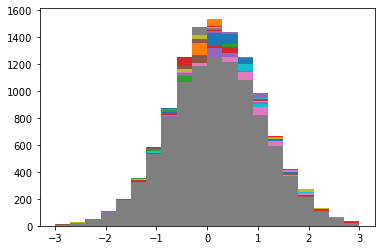

In [5]:
%%time


for di in range( n_input_dirs ) :
    
    in_dir = input_dirs[di]
    
    print('\n\n ====== Input dir: %s :  %s' % (in_dir, input_names[di] ) )
    print('    Unfolding type: %s ,   detector resolution:  %.2f' % (input_lhr_type[di], input_det_res[di]))
    
    with open( '%s/train-and-true-samples.npy' % in_dir, 'rb') as f :
        train_pts = np.load(f)
        train_det_pts = np.load(f)
        true_pts = np.load(f)
        true_det_pts = np.load(f)

    print('\n\n')
    print(' shape of train_pts:  %s' % str(train_pts.shape))
    print(' shape of true_pts:   %s' % str(true_pts.shape))

    
    with open( "%s/omnifold-output-weights.npy" % in_dir,'rb') as f :
        main_sample_omnifold_weights = np.load(f)

    main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

    print('\n\n')
    print(' shape of main_sample_omnifold_weights: %s' % str(main_sample_omnifold_weights.shape))

    
    unfolded_hist,hist_bin_edges,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )

    hist_bin_centers = np.zeros( hist_nbins )
    for bi in range(hist_nbins) :
        hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])    
    
    bin_width = hist_bin_edges[1] - hist_bin_edges[0]
    
    weight_sum = np.sum( main_sample_omnifold_weights )
    print('\n\n Sum of ominfold weights:  %.3f' % weight_sum )
    
    mean_cov = calc_mean_cov( main_sample_omnifold_weights, 0, 0 )
    
    print( '\n Simple calculation of model pars:     mean = %.5f,     sig2 = %.5f' %
         (mean_cov['mean_x1'], mean_cov['cov_x1x2']))

    
    
    n_samples = 0

    for fi in range(5000) :

        fname = '%s/bootstrap-weights-%03d.npy' % (in_dir, fi)

        if exists(fname) :
            n_samples = n_samples + 1

    print("\n Found %d bootstrap samples.\n\n" % n_samples )    
    

    #--
    
    boot_hist_content = np.zeros( shape=(n_samples, hist_nbins))


    simple_calc_mean = np.zeros( n_samples )
    simple_calc_cov  = np.zeros( n_samples )


    for bi in range(n_samples) :

        #boot_hist_content.append()

        fname = '%s/bootstrap-weights-%03d.npy' % (in_dir, bi)

        if not exists(fname) :  
            print('\n\n *** Missing %s' % fname )
            continue

        with open(fname,'rb') as f :

            final_push_weights_scaled = np.load(f)
            print(' boot %3d weights: ' % bi, end='')
            print( final_push_weights_scaled)

            hist_content,_,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=final_push_weights_scaled, range=[hist_xlow, hist_xhigh] )

            boot_hist_content[bi,:] = hist_content


            mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

            simple_calc_mean[bi] = mean_cov['mean_x1']
            simple_calc_cov[bi]  = mean_cov['cov_x1x2']
    

    #--

    simple_calc_ave_mean = np.mean( simple_calc_mean )
    simple_calc_ave_mean2 = np.mean( simple_calc_mean * simple_calc_mean )
    simple_calc_rms_mean = np.sqrt( simple_calc_ave_mean2 - simple_calc_ave_mean * simple_calc_ave_mean )

    
    simple_calc_ave_sig2 = np.mean( simple_calc_cov )
    simple_calc_ave_sig22 = np.mean( simple_calc_cov * simple_calc_cov )
    simple_calc_rms_sig2 = np.sqrt( simple_calc_ave_sig22 - simple_calc_ave_sig2 * simple_calc_ave_sig2 )
      
    
    #--
    
    hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
    hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

    for bi in range(hist_nbins) :

        for bj in range( hist_nbins ) :

            ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
            cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )

            hist_corr_mat[bi,bj] = ccm[0,1]

            hist_cov_mat[bi,bj] = cvm[0,1]

            if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant

    #--
    
    hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )
    
    #--
    
    hist_cov_mat_diagonal = np.copy( hist_cov_mat )
    for bi in range(hist_nbins) :
        for bj in range(hist_nbins) :
            if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.
            
    hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
    print(hist_cov_inv_diagonal)        
    
    #--
    

    chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
    chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

    chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
    chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

    chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
    chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

    chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
    chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



    for si in range( len(boot_hist_content) ) :

        # Initialize Minuit and set up fit:
        theta = 1
        mu = 0.2
        sigma2 = 0.81
        #fitType = 'full cov'

        parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
        parname = ['theta', 'mu', 'sigma2']
        parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
        parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
        parfix  = [False, False, False]            # change to fix/free param.
        parlim  = [(0.5, 1.5), (None, None), (0., None)]

        chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
        chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


        m = Minuit(chisq, parin, name=parname)
        m.errors = parstep
        m.fixed = parfix
        m.limits = parlim
        m.errordef = 1.0                      # errors from chi2 = chi2min + 1


        m_diag = Minuit(chisq_diag, parin, name=parname)
        m_diag.errors = parstep
        m_diag.fixed = parfix
        m_diag.limits = parlim
        m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    


        # do the fit, get errors, extract results
        m.migrad()                                        # minimize -logL
        parhat = m.values                                 # max-likelihood estimates
        sigma_parhat = m.errors                           # standard deviations
        cov = m.covariance                                # covariance matrix
        rho = m.covariance.correlation()                  # correlation coeffs.

        m_diag.migrad()                                        # minimize -logL
        parhat_diag = m_diag.values                                 # max-likelihood estimates
        sigma_parhat_diag = m_diag.errors                           # standard deviations
        cov_diag = m_diag.covariance                                # covariance matrix
        rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.


        chi2_fit_mu_val[si] = parhat[1]
        chi2_fit_mu_err[si] = sigma_parhat[1]

        chi2_fit_sig2_val[si] = parhat[2]
        chi2_fit_sig2_err[si] = sigma_parhat[2]


        chi2_fit_diag_mu_val[si] = parhat_diag[1]
        chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

        chi2_fit_diag_sig2_val[si] = parhat_diag[2]
        chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]


        print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
              (si, 
               parhat[1], sigma_parhat[1],
               parhat_diag[1], sigma_parhat_diag[1],
               parhat[2], sigma_parhat[2],
               parhat_diag[2], sigma_parhat_diag[2],
              )
             )

    #--


    mean_mu = np.mean( chi2_fit_mu_val )
    mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
    rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

    mean_sig2 = np.mean( chi2_fit_sig2_val )
    mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
    rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

    mean_mu_fit_err = np.mean( chi2_fit_mu_err )
    mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )
    
    
    mean_mu_fit_err2 = np.mean( chi2_fit_mu_err * chi2_fit_mu_err )
    mean_mu_fit_err_rms = np.sqrt( mean_mu_fit_err2 - mean_mu_fit_err * mean_mu_fit_err )

    mean_sig2_fit_err2 = np.mean( chi2_fit_sig2_err * chi2_fit_sig2_err )
    mean_sig2_fit_err_rms = np.sqrt( mean_sig2_fit_err2 - mean_sig2_fit_err * mean_sig2_fit_err )
    
    
    



    mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
    mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
    rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

    mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
    mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
    rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

    mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
    mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )


    
    mean_mu_fit_err2_diag = np.mean( chi2_fit_diag_mu_err * chi2_fit_diag_mu_err )
    mean_mu_fit_err_rms_diag = np.sqrt( mean_mu_fit_err2_diag - mean_mu_fit_err_diag * mean_mu_fit_err_diag )

    mean_sig2_fit_err2_diag = np.mean( chi2_fit_diag_sig2_err * chi2_fit_diag_sig2_err )
    mean_sig2_fit_err_rms_diag = np.sqrt( mean_sig2_fit_err2_diag - mean_sig2_fit_err_diag * mean_sig2_fit_err_diag )

    
    
    
    
    


    print('\n\n')
    print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
          (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
    print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
          (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
    print('\n\n')

    
    
    #-- Model mean
    
    pi = 0
    
    ii = 0
    results_inference_mean[di, ii, pi] = simple_calc_ave_mean
    results_rms[di, ii, pi] = simple_calc_rms_mean
    
    ii = 1
    results_inference_mean[di, ii, pi] = mean_mu
    results_fit_err[di, ii, pi] = mean_mu_fit_err
    results_rms[di, ii, pi] = rms_mu
    
    ii = 2
    results_inference_mean[di, ii, pi] = mean_mu_diag
    results_fit_err[di, ii, pi] = mean_mu_fit_err_diag
    results_rms[di, ii, pi] = rms_mu_diag
    

    
    #-- stat err on above
    
    ii = 0
    results_inference_mean_stat_err[di, ii, pi] = simple_calc_rms_mean / np.sqrt( n_samples )    
    results_rms_stat_err[di, ii, pi] = simple_calc_rms_mean / np.sqrt( 2 * n_samples )
    
    ii = 1
    results_inference_mean_stat_err[di, ii, pi] = rms_mu / np.sqrt( n_samples )
    results_fit_err_stat_err[di, ii, pi] = mean_mu_fit_err_rms / np.sqrt( n_samples )
    results_rms_stat_err[di, ii, pi] = rms_mu / np.sqrt( 2 * n_samples )
    
    
    ii = 2
    results_inference_mean_stat_err[di, ii, pi] = rms_mu_diag / np.sqrt( n_samples )
    results_fit_err_stat_err[di, ii, pi] = mean_mu_fit_err_rms_diag / np.sqrt( n_samples )
    results_rms_stat_err[di, ii, pi] = rms_mu_diag / np.sqrt( 2 * n_samples ) 
    
    
    
    
    
    
    
    
    
    #-- Model sig2
    
    pi = 1
    
    ii = 0
    results_inference_mean[di, ii, pi] = simple_calc_ave_sig2
    results_rms[di, ii, pi] = simple_calc_rms_sig2
    
    ii = 1
    results_inference_mean[di, ii, pi] = mean_sig2
    results_fit_err[di, ii, pi] = mean_sig2_fit_err
    results_rms[di, ii, pi] = rms_sig2
    
    ii = 2
    results_inference_mean[di, ii, pi] = mean_sig2_diag
    results_fit_err[di, ii, pi] = mean_sig2_fit_err_diag
    results_rms[di, ii, pi] = rms_sig2_diag

    
    
    #-- stat err on above
    
    ii = 0
    results_inference_mean_stat_err[di, ii, pi] = simple_calc_rms_sig2 / np.sqrt( n_samples )    
    results_rms_stat_err[di, ii, pi] = simple_calc_rms_sig2 / np.sqrt( 2 * n_samples )
    
    ii = 1
    results_inference_mean_stat_err[di, ii, pi] = rms_sig2 / np.sqrt( n_samples )
    results_fit_err_stat_err[di, ii, pi] = mean_sig2_fit_err_rms / np.sqrt( n_samples )
    results_rms_stat_err[di, ii, pi] = rms_sig2 / np.sqrt( 2 * n_samples )
    
    
    ii = 2
    results_inference_mean_stat_err[di, ii, pi] = rms_sig2_diag / np.sqrt( n_samples )
    results_fit_err_stat_err[di, ii, pi] = mean_sig2_fit_err_rms_diag / np.sqrt( n_samples )
    results_rms_stat_err[di, ii, pi] = rms_sig2_diag / np.sqrt( 2 * n_samples ) 
  

    #--

    
    
    
    
    
    
    
    
    
    
    
    
    have_fits = False

    if exists( "%s/fit-results.npy" % in_dir ) :
        have_fits = True
        print("\n\n Have fit results file.\n\n")
        
    if have_fits :
        
        ndim = 1

        with open( '%s/fit-results.npy' % in_dir, 'rb' ) as f :
            fit_results_mean_val = np.load(f, allow_pickle=True )
            fit_results_mean_err = np.load(f, allow_pickle=True )
            fit_results_cov_val = np.load(f, allow_pickle=True )
            fit_results_cov_err = np.load(f, allow_pickle=True )        


        ave_fit_err_mean = np.zeros( ndim )

        ave_fit_err_cov = np.zeros( shape=(ndim,ndim) )

        for fi in range(ndim) :

            ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])

            print( '%d : ave fit error, mean :  %8.4f' % (fi, ave_fit_err_mean[fi]))

        for fi1 in range(ndim) :
            for fi2 in range(fi1,ndim) :


                ave_fit_err_cov[fi1,fi2] = np.mean( fit_results_cov_err[fi1,fi2,:])

                print( 'fi1, fi2 : %d, %d    ave fit error, cov : %8.4f' % (fi1,fi2, ave_fit_err_cov[fi1,fi2]))

                
        ii = 0
        
        pi = 0
        results_fit_err[di, ii, pi] = ave_fit_err_mean[0]

        pi = 1
        results_fit_err[di, ii, pi] = ave_fit_err_cov[0,0]
                

    print('\n ====== End of this dir: %s :  %s' % (in_dir, input_names[di] ) )
                

In [6]:
results_inference_mean

array([[[0.1998364 , 0.81124344],
        [0.19952403, 0.81086808],
        [0.19975542, 0.81094584]],

       [[0.20145391, 0.81132219],
        [0.20017071, 0.8127998 ],
        [0.20110879, 0.81143876]],

       [[0.20308701, 0.81280356],
        [0.19780886, 0.8218288 ],
        [0.20314723, 0.81173412]],

       [[0.19955111, 0.82993606],
        [0.20270865, 0.8576188 ],
        [0.19815714, 0.82156684]],

       [[0.19975565, 0.81219706],
        [0.18930094, 0.79785586],
        [0.19934966, 0.81077666]],

       [[0.20026437, 0.81256706],
        [0.20107001, 0.80621641],
        [0.20120046, 0.8113564 ]],

       [[0.19979314, 0.81302739],
        [0.20000249, 0.81542363],
        [0.20032651, 0.81735912]],

       [[0.19771217, 0.83710992],
        [0.1963281 , 0.83306651],
        [0.19969606, 0.83832335]]])

In [7]:
results_fit_err

array([[[0.00898017, 0.01141702],
        [0.00901264, 0.01208731],
        [0.00844234, 0.01122122]],

       [[0.00899814, 0.01146101],
        [0.00944792, 0.01405429],
        [0.00852224, 0.01145393]],

       [[0.00900686, 0.01148085],
        [0.00977085, 0.01699891],
        [0.00670984, 0.00901669]],

       [[0.0091229 , 0.01177783],
        [0.01187619, 0.0161104 ],
        [0.00579109, 0.00791556]],

       [[0.00900401, 0.0114754 ],
        [0.01118106, 0.0149322 ],
        [0.00581733, 0.00753756]],

       [[0.00900504, 0.01148199],
        [0.01114499, 0.01412657],
        [0.0060846 , 0.00829583]],

       [[0.00900316, 0.01147379],
        [0.01213193, 0.0169209 ],
        [0.00673434, 0.00933944]],

       [[0.00913968, 0.01181997],
        [0.01307165, 0.01859167],
        [0.00717865, 0.01013065]]])

In [8]:
results_rms

array([[[0.00912431, 0.01160895],
        [0.00895343, 0.01197889],
        [0.00914859, 0.01208735]],

       [[0.00955335, 0.01221911],
        [0.00940894, 0.01391594],
        [0.0097346 , 0.01303624]],

       [[0.01017595, 0.01511853],
        [0.00959265, 0.01728111],
        [0.01034331, 0.01542081]],

       [[0.01212796, 0.01721512],
        [0.01181501, 0.01555205],
        [0.01217535, 0.01738661]],

       [[0.01131814, 0.01386989],
        [0.01109661, 0.01603571],
        [0.0115262 , 0.01420875]],

       [[0.01122775, 0.014154  ],
        [0.0111252 , 0.0142311 ],
        [0.01177096, 0.01514623]],

       [[0.01220829, 0.01620525],
        [0.01211766, 0.01735603],
        [0.01323343, 0.01782066]],

       [[0.01311604, 0.01884462],
        [0.01308757, 0.01852772],
        [0.01393863, 0.01976377]]])

In [9]:
results_inference_mean_stat_err 

array([[[0.00040805, 0.00051917],
        [0.00040041, 0.00053571],
        [0.00040914, 0.00054056]],

       [[0.00042724, 0.00054646],
        [0.00042078, 0.00062234],
        [0.00043534, 0.000583  ]],

       [[0.00045508, 0.00067612],
        [0.000429  , 0.00077283],
        [0.00046257, 0.00068964]],

       [[0.00054238, 0.00076988],
        [0.00052838, 0.00069551],
        [0.0005445 , 0.00077755]],

       [[0.00035791, 0.0004386 ],
        [0.00035091, 0.00050709],
        [0.00036449, 0.00044932]],

       [[0.00035505, 0.00044759],
        [0.00035181, 0.00045003],
        [0.00037223, 0.00047897]],

       [[0.00038606, 0.00051245],
        [0.00038319, 0.00054885],
        [0.00041848, 0.00056354]],

       [[0.00041477, 0.00059592],
        [0.00041387, 0.0005859 ],
        [0.00044078, 0.00062499]]])

In [10]:
results_fit_err_stat_err

array([[[0.00000000e+00, 0.00000000e+00],
        [3.14246433e-07, 5.90986391e-06],
        [6.52498712e-07, 5.42696758e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [7.15725115e-07, 8.44069046e-06],
        [8.35367214e-07, 6.19988165e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [7.63475837e-07, 1.13239710e-05],
        [9.49935630e-07, 5.44635950e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [5.19610695e-07, 1.09912194e-05],
        [1.21894781e-06, 4.19368883e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [2.64472146e-06, 1.06879029e-05],
        [1.57667735e-06, 3.00448728e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [2.69725703e-06, 8.24481362e-06],
        [1.96593484e-06, 4.22318649e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [3.01512155e-06, 9.70338866e-06],
        [2.38832450e-06, 5.26840974e-06]],

       [[0.00000000e+00, 0.00000000e+00],
        [3.07799472e-06, 1.11300474e-05],
        [2.80338907e

In [11]:
results_rms_stat_err

array([[[0.00028854, 0.00036711],
        [0.00028313, 0.00037881],
        [0.0002893 , 0.00038224]],

       [[0.0003021 , 0.0003864 ],
        [0.00029754, 0.00044006],
        [0.00030784, 0.00041224]],

       [[0.00032179, 0.00047809],
        [0.00030335, 0.00054648],
        [0.00032708, 0.00048765]],

       [[0.00038352, 0.00054439],
        [0.00037362, 0.0004918 ],
        [0.00038502, 0.00054981]],

       [[0.00025308, 0.00031014],
        [0.00024813, 0.00035857],
        [0.00025773, 0.00031772]],

       [[0.00025106, 0.00031649],
        [0.00024877, 0.00031822],
        [0.00026321, 0.00033868]],

       [[0.00027299, 0.00036236],
        [0.00027096, 0.00038809],
        [0.00029591, 0.00039848]],

       [[0.00029328, 0.00042138],
        [0.00029265, 0.00041429],
        [0.00031168, 0.00044193]]])

In [12]:
with open( 'inference-analysis-results.npy', 'wb' ) as f :
    np.save( f, results_inference_mean )
    np.save( f, results_fit_err )
    np.save( f, results_rms )
    np.save( f, results_inference_mean_stat_err )
    np.save( f, results_fit_err_stat_err )
    np.save( f, results_rms_stat_err )    